## Comprehensive Backtesting and Optimization of VWAP + Candlestick Pattern Strategies

This notebook implements a complete trading strategy analysis framework combining VWAP (Volume Weighted Average Price) with various candlestick patterns for systematic backtesting, optimization, and performance evaluation.

## 1. Environment Setup and Data Loading

In [350]:
# Import all necessary libraries
import pandas as pd
import numpy as np
import talib as ta
import random
import warnings
from datetime import datetime, timedelta
# import time
from typing import List, Dict, Tuple, Optional
import concurrent.futures

import os
from pathlib import Path

# Backtesting libraries
from backtesting import Strategy, Backtest
from backtesting.lib import crossover

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import seaborn as sns
from IPython.display import display, HTML

# Optimization and statistics
from scipy import stats
from sklearn.model_selection import TimeSeriesSplit

# Configure warnings and display settings
import warnings
warnings.filterwarnings("ignore")

import traceback

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
%matplotlib inline

In [351]:
# import yfinance as yf

# def download_data(tickers, start_date, end_date=None, save_path=None):
#     """
#     Download historical stock data from Yahoo Finance and save to CSV.
    
#     Parameters:
#     -----------
#     tickers : list
#         List of stock ticker symbols (e.g., ['AAPL', 'MSFT', 'GOOGL'])
#     start_date : str
#         Start date in format "YYYY-MM-DD"
#     end_date : str, optional
#         End date in format "YYYY-MM-DD". If None, uses current date
#     save_path : str, optional
#         Custom path to save CSV. If None, uses auto-generated name
    
#     Returns:
#     --------
#     pd.DataFrame
#         Downloaded stock data with MultiIndex columns (Ticker, OHLCV)
#     str
#         Path where the CSV file was saved
#     """
    
#     # Set end_date to current date if not provided
#     if end_date is None:
#         end_date = datetime.now().strftime("%Y-%m-%d")
    
#     # Download data from Yahoo Finance
#     print(f"Downloading data for {len(tickers)} tickers from {start_date} to {end_date}...")
#     data = yf.download(tickers, start=start_date, end=end_date, group_by='ticker')
    
#     # Generate filename if not provided
#     if save_path is None:
#         tickers_str = "_".join(tickers)
#         filename = f"data_{tickers_str}_{start_date}_{end_date}_raw.csv"
#     else:
#         filename = save_path
    
#     # Save to CSV
#     data.to_csv(filename)
#     print(f"Data saved to: {filename}")
    
#     # Load the CSV back with proper MultiIndex structure
#     df = pd.read_csv(filename, header=[0,1], index_col=0)
    
#     # Clean the data
#     df = df.dropna(how='all')  # Drop completely NaN rows
#     df = df.astype(float)      # Convert to float
    
#     print(f"Data shape: {df.shape}")
#     print("Download completed successfully!")
    
#     return df, filename

# # Example usage:
# if __name__ == "__main__":
#     # Define portfolio
#     tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA', 'META', 'NVDA']
    
#     # Download data
#     df, saved_file = download_data(
#         tickers=tickers,
#         start_date="2020-01-01",
#         end_date=None  # Indicate specific date ("YYYY-MM-DD") or leave None for current date
#     )
    
#     # Show result
#     print(f"\nFirst 5 rows of downloaded data:")
#     print(df.head())

In [352]:
# Load and validate data
def load_market_data(file_path: str) -> pd.DataFrame:
    """
    Load market data from CSV with proper error handling
    """
    try:
        # Load the CSV with MultiIndex columns (Tickers, OHLCV)
        df = pd.read_csv(file_path, header=[0,1], index_col=0)
        
        # Drop any rows that are completely NaN
        df = df.dropna(how='all')
        
        # Convert all values to float
        df = df.astype(float)
        
        # Convert index to datetime
        df.index = pd.to_datetime(df.index)

        print(f"Data loaded successfully: {df.shape}")
        print(f"Date range: {df.index.min()} to {df.index.max()}")
        print(f"Tickers: {list(df.columns.levels[0])}")

        return df
        
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        raise
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        raise

# Load the data
data_path = "../00_data/data_AAPL_MSFT_GOOGL_AMZN_TSLA_META_NVDA_2020-01-01_2025-11-08_raw.csv"
df_raw = load_market_data(data_path)

# Display data info
print("\nData Overview:")
df_raw.tail()

Data loaded successfully: (1472, 35)
Date range: 2020-01-02 00:00:00 to 2025-11-07 00:00:00
Tickers: ['AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA']

Data Overview:


Ticker            MSFT                                                  \
Price             Open        High         Low       Close      Volume   
Date                                                                     
2025-11-03  519.809998  524.960022  514.590027  517.030029  22374700.0   
2025-11-04  511.760010  515.549988  507.839996  514.330017  20958700.0   
2025-11-05  513.299988  514.830017  506.579987  507.160004  23024300.0   
2025-11-06  505.660004  505.700012  495.809998  497.100006  27406500.0   
2025-11-07  496.679993  499.377014  493.250000  496.820007  22519748.0   

Ticker            AMZN                                                  ...  \
Price             Open        High         Low       Close      Volume  ...   
Date                                                                    ...   
2025-11-03  255.360001  258.600006  252.899994  254.000000  95997800.0  ...   
2025-11-04  250.380005  257.010010  248.660004  249.320007  51546300.0  ...   
2025-11-05  249.029999  251.000000  246.160004  250.199997  40610700.0  ...   
2025-11-06  249.160004  250.380005  242.169998  243.039993  46004200.0  ...   
2025-11-07  242.899994  244.899994  238.490005  244.410004  43907627.0  ...   

Ticker            TSLA                                                   \
Price             Open        High         Low       Close       Volume   
Date                                                                      
2025-11-03  455.989990  474.070007  453.799988  468.369995   84595200.0   
2025-11-04  454.459991  460.220001  443.600006  444.260010   87756600.0   
2025-11-05  452.049988  466.329987  440.709991  462.070007   85573000.0   
2025-11-06  461.959991  467.450012  435.089996  445.910004  109622900.0   
2025-11-07  437.890015  437.942505  421.880005  429.519989  101473925.0   

Ticker           GOOGL                                                  
Price             Open        High         Low       Close      Volume  
Date                                                                    
2025-11-03  282.179993  285.529999  279.799988  283.720001  29786000.0  
2025-11-04  276.750000  281.269989  276.260010  277.540009  30078400.0  
2025-11-05  278.869995  286.420013  277.339996  284.309998  31010300.0  
2025-11-06  285.329987  288.350006  281.140015  284.750000  37173600.0  
2025-11-07  283.130005  283.779999  275.190002  278.829987  32814187.0  

[5 rows x 35 columns]

## 2. Data Preprocessing and Ticker Selection

In [353]:
"""
Need to use select_random_ticker() or select_ticker() as alternative
""";

In [354]:
def select_random_ticker(df: pd.DataFrame, seed: Optional[int] = None) -> Tuple[str, pd.DataFrame]:
    """
    Select a random ticker and return cleaned data
    """
    if seed:
        random.seed(seed)
        np.random.seed(seed)
    
    # Get available tickers
    tickers = list(df.columns.levels[0])
    selected_ticker = random.choice(tickers)
    
    print(f"Randomly selected ticker: {selected_ticker}")
    
    # Extract data for selected ticker
    ticker_data = df.xs(selected_ticker, level=0, axis=1)
    
    # Clean column names (lowercase)
    ticker_data.columns = [col.lower() for col in ticker_data.columns]
    
    # Remove any remaining NaN values
    ticker_data = ticker_data.dropna()
    
    print(f"Clean data shape: {ticker_data.shape}")
    print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
    
    return selected_ticker, ticker_data

# Select ticker and prepare data
# RANDOM_SEED = 42  # For reproducibility
# RANDOM_SEED should have also the possibility to randomly select an integer, 
# so that different runs can analyze different tickers
RANDOM_SEED = random.randint(1, 100)
ticker_name, df_clean = select_random_ticker(df_raw, seed=RANDOM_SEED)

# Display cleaned data
print(f"\nSample data for {ticker_name}:")
display(df_clean.head())
print(f"\nData statistics:")
display(df_clean.describe())

Randomly selected ticker: GOOGL
Clean data shape: (1472, 5)
Date range: 2020-01-02 00:00:00 to 2025-11-07 00:00:00

Sample data for GOOGL:


,open,high,low,close,volume
Date,,,,,
2020-01-02,66.958679,67.965233,66.863336,67.965233,27278000.0
2020-01-03,66.938308,68.216987,66.904537,67.609673,23408000.0
2020-01-06,67.118577,69.437089,67.087298,69.411766,46768000.0
2020-01-07,69.543349,69.694308,69.101397,69.277679,34330000.0
2020-01-08,69.263289,70.108958,69.154542,69.770790,35314000.0



Data statistics:


,open,high,low,close,volume
count,1472.000000,1472.000000,1472.000000,1472.000000,1.472000e+03
mean,129.292781,130.811129,127.867665,129.383609,3.350361e+07
std,42.340703,42.744190,41.931220,42.374583,1.475970e+07
min,52.456703,52.980093,50.097971,52.345470,9.312000e+06
25%,98.016463,99.429231,96.616126,98.170410,2.400310e+07
50%,128.533482,130.177158,126.989149,128.330391,2.992210e+07
75%,155.497016,157.930077,153.726680,156.071659,3.807275e+07
max,291.589996,291.589996,281.140015,284.750000,1.274901e+08


### Add date filtering

In [355]:
# # Date filtering
# start_date = "2022-01-01"
# end_date = "2023-01-01"

# df_clean = df_clean[(df_clean.index >= start_date) & (df_clean.index <= end_date)]

# # Display filtered data
# print(f"\nFiltered data for {ticker_name} from {start_date} to {end_date}:")
# display(df_clean.head())

### Select specific ticker

In [356]:
# def select_ticker(df, ticker):
#     """
#     Select data for a specific ticker from MultiIndex DataFrame.
    
#     Parameters:
#     -----------
#     df : pd.DataFrame
#         MultiIndex DataFrame with (Ticker, OHLCV) structure
#     ticker : str
#         Ticker symbol to select (e.g., 'AAPL', 'MSFT', 'GOOGL')
    
#     Returns:
#     --------
#     pd.DataFrame
#         DataFrame with only the selected ticker's data
#         Columns: ['Open', 'High', 'Low', 'Close', 'Volume']
#     """
    
#     # Check if ticker exists in the DataFrame
#     available_tickers = df.columns.get_level_values(0).unique().tolist()
    
#     if ticker not in available_tickers:
#         raise ValueError(f"Ticker '{ticker}' not found. Available tickers: {available_tickers}")
    
#     # Select the ticker from level 0 of MultiIndex
#     ticker_data = df[ticker].copy()
    
#     print(f"Selected data for {ticker}")
#     print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
#     print(f"Shape: {ticker_data.shape}")
    
#     return ticker_data

# # # Enhanced version with additional functionality
# # def select_ticker_advanced(df, ticker, columns=None, start_date=None, end_date=None):
# #     """
# #     Select data for a specific ticker with additional filtering options.
    
# #     Parameters:
# #     -----------
# #     df : pd.DataFrame
# #         MultiIndex DataFrame with (Ticker, OHLCV) structure
# #     ticker : str
# #         Ticker symbol to select
# #     columns : list, optional
# #         Specific columns to select (e.g., ['Open', 'Close'])
# #     start_date : str, optional
# #         Start date for filtering (format: 'YYYY-MM-DD')
# #     end_date : str, optional
# #         End date for filtering (format: 'YYYY-MM-DD')
    
# #     Returns:
# #     --------
# #     pd.DataFrame
# #         Filtered DataFrame for the selected ticker
# #     """
    
# #     # Get available tickers
# #     available_tickers = df.columns.get_level_values(0).unique().tolist()
    
# #     if ticker not in available_tickers:
# #         raise ValueError(f"Ticker '{ticker}' not found. Available tickers: {available_tickers}")
    
# #     # Select ticker data
# #     ticker_data = df[ticker].copy()
    
# #     # Filter by columns if specified
# #     if columns is not None:
# #         available_columns = ticker_data.columns.tolist()
# #         invalid_columns = [col for col in columns if col not in available_columns]
        
# #         if invalid_columns:
# #             raise ValueError(f"Invalid columns {invalid_columns}. Available: {available_columns}")
        
# #         ticker_data = ticker_data[columns]
    
# #     # Filter by date range if specified
# #     if start_date is not None:
# #         ticker_data = ticker_data[ticker_data.index >= start_date]
    
# #     if end_date is not None:
# #         ticker_data = ticker_data[ticker_data.index <= end_date]
    
# #     print(f"Selected data for {ticker}")
# #     if columns:
# #         print(f"Columns: {columns}")
# #     print(f"Date range: {ticker_data.index.min()} to {ticker_data.index.max()}")
# #     print(f"Shape: {ticker_data.shape}")
    
# #     return ticker_data

# # # Utility function to list available tickers
# # def list_available_tickers(df):
# #     """
# #     List all available tickers in the MultiIndex DataFrame.
    
# #     Parameters:
# #     -----------
# #     df : pd.DataFrame
# #         MultiIndex DataFrame
    
# #     Returns:
# #     --------
# #     list
# #         List of available ticker symbols
# #     """
# #     tickers = df.columns.get_level_values(0).unique().tolist()
# #     print(f"Available tickers ({len(tickers)}): {tickers}")
# #     return tickers

In [357]:
# # Basic usage - select all data for NVDA
# ticker_name = 'NVDA'
# ticker_data = select_ticker(df_raw, ticker_name)
# # Clean column names (lowercase)
# ticker_data.columns = [col.lower() for col in ticker_data.columns]
# df_clean = ticker_data.copy()
# print(ticker_data.head())

# # # Advanced usage - select specific columns
# # aapl_price = select_ticker_advanced(df_raw, 'AAPL', columns=['Open', 'Close'])

# # # Advanced usage - select data for specific date range
# # googl_recent = select_ticker_advanced(
# #     df_raw, 'GOOGL', 
# #     start_date='2024-01-01', 
# #     end_date='2024-12-31'
# # )

# # # Advanced usage - combine filters
# # meta_filtered = select_ticker_advanced(
# #     df_raw, 'META',
# #     columns=['Close', 'Volume'],
# #     start_date='2023-01-01'
# # )

# # # List all available tickers
# # available_tickers = list_available_tickers(df_raw)

## 3. Indicator Calculation Functions

In [358]:
# Define all indicator calculation functions
def calculate_vwap(df: pd.DataFrame) -> pd.Series:
    """Calculate VWAP (Volume Weighted Average Price)"""
    try:
        typical_price = (df['high'] + df['low'] + df['close']) / 3
        vwap = (df['volume'] * typical_price).cumsum() / df['volume'].cumsum()
        return vwap
    except Exception as e:
        print(f"Error calculating VWAP: {e}")
        return pd.Series(index=df.index, dtype=float)

def calculate_atr(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """Calculate ATR (Average True Range)"""
    try:
        high_low = df['high'] - df['low']
        high_close = (df['high'] - df['close'].shift()).abs()
        low_close = (df['low'] - df['close'].shift()).abs()
        true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        atr = true_range.rolling(window=period).mean()
        return atr
    except Exception as e:
        print(f"Error calculating ATR: {e}")
        return pd.Series(index=df.index, dtype=float)

def calculate_candlestick_pattern(df: pd.DataFrame, pattern_name: str) -> pd.Series:
    """Calculate a specific candlestick pattern"""
    try:
        pattern_func = getattr(ta, pattern_name)
        result = pattern_func(df['open'], df['high'], df['low'], df['close'])
        return pd.Series(result, index=df.index)
    except Exception as e:
        print(f"Error calculating {pattern_name}: {e}")
        return pd.Series(index=df.index, dtype=float)

# Define all candlestick patterns
CANDLESTICK_PATTERNS = [
    # Bullish reversal patterns
    'CDLHAMMER', 'CDLINVERTEDHAMMER', 'CDLMORNINGSTAR', 'CDLMORNINGDOJISTAR',
    'CDLENGULFING', 'CDLPIERCING', 'CDLHARAMI', 'CDLHARAMICROSS', 'CDLTAKURI',
    
    # Bullish continuation patterns  
    'CDL3WHITESOLDIERS', 'CDLRISEFALL3METHODS', 'CDLMATHOLD', 
    'CDLSEPARATINGLINES', 'CDLTASUKIGAP',
    
    # Bullish bottom patterns
    'CDLABANDONEDBABY', 'CDLLADDERBOTTOM', 'CDLMATCHINGLOW', 'CDLUNIQUE3RIVER',
    
    # Bullish special patterns
    'CDL3INSIDE', 'CDL3OUTSIDE', 'CDLBELTHOLD', 'CDLBREAKAWAY',
    'CDLKICKING', 'CDLKICKINGBYLENGTH', 'CDLSTICKSANDWICH'
]

print(f"Available candlestick patterns: {len(CANDLESTICK_PATTERNS)}")
for i, pattern in enumerate(CANDLESTICK_PATTERNS, 1):
    print(f"{i:2d}. {pattern}")

Available candlestick patterns: 25
 1. CDLHAMMER
 2. CDLINVERTEDHAMMER
 3. CDLMORNINGSTAR
 4. CDLMORNINGDOJISTAR
 5. CDLENGULFING
 6. CDLPIERCING
 7. CDLHARAMI
 8. CDLHARAMICROSS
 9. CDLTAKURI
10. CDL3WHITESOLDIERS
11. CDLRISEFALL3METHODS
12. CDLMATHOLD
13. CDLSEPARATINGLINES
14. CDLTASUKIGAP
15. CDLABANDONEDBABY
16. CDLLADDERBOTTOM
17. CDLMATCHINGLOW
18. CDLUNIQUE3RIVER
19. CDL3INSIDE
20. CDL3OUTSIDE
21. CDLBELTHOLD
22. CDLBREAKAWAY
23. CDLKICKING
24. CDLKICKINGBYLENGTH
25. CDLSTICKSANDWICH


## 4. Strategy Configuration and Generation

In [359]:
def generate_strategy_configs(patterns: List[str]) -> List[Dict]:
    """
    Generate strategy configurations for all VWAP + candlestick combinations
    """
    strategies = []
    
    for pattern in patterns:
        strategy_config = {
            'name': f'VWAP_{pattern}',
            'primary_indicator': 'VWAP',
            'secondary_indicator': pattern,
            'description': f'VWAP combined with {pattern} candlestick pattern',
            'atr_period': 14,
            'sl_multiplier': 1.5,
            'tp_multiplier': 3.0,
            'pattern_function': pattern
        }
        strategies.append(strategy_config)
    
    return strategies

# Generate all strategy configurations
strategy_configs = generate_strategy_configs(CANDLESTICK_PATTERNS)

print(f"Generated {len(strategy_configs)} strategy configurations:")
print("\nStrategy List:")
for i, config in enumerate(strategy_configs[:10], 1):  # Show first 10
    print(f"{i:2d}. {config['name']} - {config['description']}")

if len(strategy_configs) > 10:
    print(f"    ... and {len(strategy_configs) - 10} more strategies")

print(f"\nSample strategy configuration:")
display(pd.DataFrame([strategy_configs[0]]).T)

Generated 25 strategy configurations:

Strategy List:
 1. VWAP_CDLHAMMER - VWAP combined with CDLHAMMER candlestick pattern
 2. VWAP_CDLINVERTEDHAMMER - VWAP combined with CDLINVERTEDHAMMER candlestick pattern
 3. VWAP_CDLMORNINGSTAR - VWAP combined with CDLMORNINGSTAR candlestick pattern
 4. VWAP_CDLMORNINGDOJISTAR - VWAP combined with CDLMORNINGDOJISTAR candlestick pattern
 5. VWAP_CDLENGULFING - VWAP combined with CDLENGULFING candlestick pattern
 6. VWAP_CDLPIERCING - VWAP combined with CDLPIERCING candlestick pattern
 7. VWAP_CDLHARAMI - VWAP combined with CDLHARAMI candlestick pattern
 8. VWAP_CDLHARAMICROSS - VWAP combined with CDLHARAMICROSS candlestick pattern
 9. VWAP_CDLTAKURI - VWAP combined with CDLTAKURI candlestick pattern
10. VWAP_CDL3WHITESOLDIERS - VWAP combined with CDL3WHITESOLDIERS candlestick pattern
    ... and 15 more strategies

Sample strategy configuration:


,0
name,VWAP_CDLHAMMER
primary_indicator,VWAP
secondary_indicator,CDLHAMMER
description,VWAP combined with CDLHAMMER candlestick pattern
atr_period,14
sl_multiplier,1.5
tp_multiplier,3.0
pattern_function,CDLHAMMER


## 5. Time Series Data Splitting

In [360]:
def create_time_series_splits(df: pd.DataFrame, n_splits: int = 3) -> List[Tuple]:
    """
    Create time series cross-validation splits
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    splits = []
    
    print(f"Creating {n_splits} time series splits...")
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(df)):
        train_start = df.index[train_idx[0]]
        train_end = df.index[train_idx[-1]]
        test_start = df.index[test_idx[0]]
        test_end = df.index[test_idx[-1]]
        
        train_data = df.iloc[train_idx]
        test_data = df.iloc[test_idx]
        
        split_info = {
            'split_number': i + 1,
            'train_data': train_data,
            'test_data': test_data,
            'train_period': (train_start, train_end),
            'test_period': (test_start, test_end),
            'train_size': len(train_data),
            'test_size': len(test_data)
        }
        
        splits.append(split_info)
        
        print(f"Split {i+1}:")
        print(f"  Train: {train_start.strftime('%Y-%m-%d')} to {train_end.strftime('%Y-%m-%d')} ({len(train_data)} days)")
        print(f"  Test:  {test_start.strftime('%Y-%m-%d')} to {test_end.strftime('%Y-%m-%d')} ({len(test_data)} days)")
    
    return splits

# Create time series splits
ts_splits = create_time_series_splits(df_clean, n_splits=3)

# Use the last split for main analysis (largest training set)
main_split = ts_splits[-1]
train_data = main_split['train_data']
test_data = main_split['test_data']

print(f"\nUsing split {main_split['split_number']} for main analysis:")
print(f"Training data: {len(train_data)} days")
print(f"Testing data: {len(test_data)} days")

Creating 3 time series splits...
Split 1:
  Train: 2020-01-02 to 2021-06-17 (368 days)
  Test:  2021-06-18 to 2022-12-01 (368 days)
Split 2:
  Train: 2020-01-02 to 2022-12-01 (736 days)
  Test:  2022-12-02 to 2024-05-21 (368 days)
Split 3:
  Train: 2020-01-02 to 2024-05-21 (1104 days)
  Test:  2024-05-22 to 2025-11-07 (368 days)

Using split 3 for main analysis:
Training data: 1104 days
Testing data: 368 days


## 6. Dynamic Strategy Class Creation

In [361]:
def create_vwap_strategy_class(pattern_name: str, atr_period: int = 14, 
                              sl_multiplier: float = 1.5, tp_multiplier: float = 3.0):
    """
    Dynamically create a VWAP + Candlestick strategy class
    """
    
    class VWAPCandlestickStrategy(Strategy):
        def init(self):
            # Store parameters as instance attributes
            self.atr_period = atr_period
            self.sl_multiplier = sl_multiplier
            self.tp_multiplier = tp_multiplier
            self.pattern_name = pattern_name
            
            # Calculate VWAP
            typical_price = (self.data.High + self.data.Low + self.data.Close) / 3
            volume_price = typical_price * self.data.Volume
            self.vwap = self.I(lambda: volume_price.cumsum() / self.data.Volume.cumsum(), name='VWAP')
            
            # Calculate ATR
            self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, 
                             self.atr_period, name='ATR')
            
            # Calculate candlestick pattern
            pattern_func = getattr(ta, self.pattern_name)
            self.pattern = self.I(pattern_func, self.data.Open, self.data.High, 
                                 self.data.Low, self.data.Close, name=self.pattern_name)
            
            # Track entry levels
            """
            The entry_price uses the Close price (self.data.Close[-1]) 
            from the OHLC data when the buy signal is triggered.
            This occurs in the next() method 
            of the VWAPCandlestickStrategy class when the entry conditions are me
            """
            self.entry_price = None
            self.stop_loss_level = None
            self.take_profit_level = None
        
        def next(self):
            # Entry conditions: Price above VWAP AND bullish candlestick pattern
            if (not self.position and 
                self.data.Close[-1] > self.vwap[-1] and  # Price above VWAP
                self.pattern[-1] > 0):  # Bullish pattern detected
                
                # Enter long position
                self.buy()
                
                # Set stop loss and take profit levels
                self.entry_price = self.data.Close[-1]
                self.stop_loss_level = self.entry_price - (self.atr[-1] * self.sl_multiplier)
                self.take_profit_level = self.entry_price + (self.atr[-1] * self.tp_multiplier)
            
            # Exit conditions
            if self.position:
                # Stop Loss
                if self.data.Low[-1] <= self.stop_loss_level:
                    self.position.close()
                    self.entry_price = None
                # Take Profit  
                elif self.data.High[-1] >= self.take_profit_level:
                    self.position.close()
                    self.entry_price = None
    
    # Set class name dynamically and add attributes for debugging
    VWAPCandlestickStrategy.__name__ = f"VWAP{pattern_name}Strategy"
    VWAPCandlestickStrategy.atr_period = atr_period
    VWAPCandlestickStrategy.sl_multiplier = sl_multiplier
    VWAPCandlestickStrategy.tp_multiplier = tp_multiplier
    VWAPCandlestickStrategy.pattern_name = pattern_name
    
    return VWAPCandlestickStrategy

# Test strategy class creation using parameters from strategy_configs
print("Testing strategy class creation with config parameters...")
test_config = strategy_configs[0]  # Use first strategy config
"""
This code implements a strategy validation mechanism that tests the dynamic strategy class creation process 
using actual configuration parameters from the generated strategy pool.
This ensures that the strategy class creation function works correctly with the same parameter structure 
and data types that will be used during the full backtesting process
"""
TestStrategy = create_vwap_strategy_class(
    pattern_name=test_config['pattern_function'],
    atr_period=test_config['atr_period'],
    sl_multiplier=test_config['sl_multiplier'],
    tp_multiplier=test_config['tp_multiplier']
)
print(f"Created strategy class: {TestStrategy.__name__}")
print(f"Strategy pattern: {TestStrategy.pattern_name}")
print(f"Parameters: ATR={TestStrategy.atr_period}, SL={TestStrategy.sl_multiplier}, TP={TestStrategy.tp_multiplier}")

Testing strategy class creation with config parameters...
Created strategy class: VWAPCDLHAMMERStrategy
Strategy pattern: CDLHAMMER
Parameters: ATR=14, SL=1.5, TP=3.0


## 7. Batch Backtesting Execution

In [362]:
def run_single_backtest(strategy_config: Dict, data: pd.DataFrame, 
                       cash: float = 100000, commission: float = 0.002) -> Dict:
    """
    Run a single backtest for a strategy configuration
    """
    try:
        # Prepare data (backtesting library expects uppercase columns)
        df_backtest = data.copy()
        df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create strategy class
        StrategyClass = create_vwap_strategy_class(
            pattern_name=strategy_config['pattern_function'],
            atr_period=strategy_config['atr_period'],
            sl_multiplier=strategy_config['sl_multiplier'],
            tp_multiplier=strategy_config['tp_multiplier']
        )
        
        # Run backtest
        bt = Backtest(df_backtest, StrategyClass, cash=cash, commission=commission)
        results = bt.run()
        
        # Add strategy info to results
        result_dict = results.to_dict()
        result_dict['strategy_name'] = strategy_config['name']
        result_dict['pattern'] = strategy_config['pattern_function']
        result_dict['backtest_object'] = bt
        result_dict['success'] = True
        result_dict['error'] = None
        
        return result_dict
        
    except Exception as e:
        return {
            'strategy_name': strategy_config['name'],
            'pattern': strategy_config['pattern_function'],
            'success': False,
            'error': str(e),
            'Return [%]': 0,
            '# Trades': 0
        }

def run_batch_backtests(strategy_configs: List[Dict], data: pd.DataFrame, 
                       max_strategies: Optional[int] = None) -> pd.DataFrame:
    """
    Run backtests for multiple strategies
    """
    if max_strategies:
        configs_to_run = strategy_configs[:max_strategies]
        print(f"Running backtests for first {max_strategies} strategies...")
    else:
        configs_to_run = strategy_configs
        print(f"Running backtests for all {len(configs_to_run)} strategies...")
    
    results = []
    
    # Run backtests sequentially with progress tracking
    for i, config in enumerate(configs_to_run, 1):
        print(f"({i}/{len(configs_to_run)}) Testing {config['name']}...", end=" ")
        
        result = run_single_backtest(config, data)
        results.append(result)
        
        if result['success']:
            trades = result.get('# Trades', 0)
            returns = result.get('Return [%]', 0)
            print(f"{trades} trades, {returns:.2f}% return")
        else:
            print(f"Failed: {result['error']}")
    
    # Convert to DataFrame
    results_df = pd.DataFrame(results)
    
    # Filter successful backtests
    successful_results = results_df[results_df['success'] == True].copy()
    
    print(f"\nBacktest Summary:")
    print(f"Successful: {len(successful_results)}/{len(results_df)}")
    print(f"Failed: {len(results_df) - len(successful_results)}")

    if len(successful_results) > 0:
        print(f"Best performing strategy: {successful_results.loc[successful_results['Return [%]'].idxmax(), 'strategy_name']}")
        print(f"Best return: {successful_results['Return [%]'].max():.2f}%")
    
    return successful_results

# Run backtests on training data (limit to first 10 strategies for demo)
print("Starting batch backtesting on training data...")
train_results = run_batch_backtests(strategy_configs, train_data, max_strategies=len(strategy_configs))

# Display top performing strategies
if len(train_results) > 0:
    print(f"\nTop 5 Performing Strategies (Training Data):")
    
    # Check which columns are available in the results
    available_columns = train_results.columns.tolist()
    print(f"Available columns: {available_columns}")
    
    # Define desired columns and their alternatives
    desired_columns = {
        'strategy_name': 'strategy_name',
        'Return [%]': 'Return [%]',
        '# Trades': '# Trades', 
        'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
        'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
        'Sortino Ratio': ['Sortino Ratio', 'SortinoRatio'],
        'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown']
    }
    
    # Find which columns actually exist
    columns_to_show = []
    for desired, alternatives in desired_columns.items():
        if isinstance(alternatives, str):
            alternatives = [alternatives]
        
        found = False
        for alt in alternatives:
            if alt in available_columns:
                columns_to_show.append(alt)
                found = True
                break
        
        if not found:
            print(f"Column '{desired}' not found in results")
    
    # Display available columns
    if len(columns_to_show) > 0:
        top_strategies = train_results.nlargest(5, 'Return [%]')[columns_to_show]
        display(top_strategies)
    else:
        print("No suitable columns found for display")
        # Show first few columns of top strategies as fallback
        basic_columns = ['strategy_name', 'Return [%]', '# Trades']
        available_basic = [col for col in basic_columns if col in available_columns]
        if available_basic:
            top_strategies = train_results.nlargest(5, 'Return [%]')[available_basic]
            display(top_strategies)
        else:
            # Last resort - show all columns for top 5
            display(train_results.nlargest(5, 'Return [%]').head())

Starting batch backtesting on training data...
Running backtests for first 25 strategies...
(1/25) Testing VWAP_CDLHAMMER... 8 trades, 2.52% return
(2/25) Testing VWAP_CDLINVERTEDHAMMER... 14 trades, -8.34% return
(3/25) Testing VWAP_CDLMORNINGSTAR... 6 trades, -17.89% return
(4/25) Testing VWAP_CDLMORNINGDOJISTAR... 1 trades, -5.25% return
(5/25) Testing VWAP_CDLENGULFING... 26 trades, 27.00% return
(6/25) Testing VWAP_CDLPIERCING... 3 trades, -5.22% return
(7/25) Testing VWAP_CDLHARAMI... 24 trades, 12.92% return
(8/25) Testing VWAP_CDLHARAMICROSS... 7 trades, 26.00% return
(9/25) Testing VWAP_CDLTAKURI... 11 trades, -5.59% return
(10/25) Testing VWAP_CDL3WHITESOLDIERS... 2 trades, -6.42% return
(11/25) Testing VWAP_CDLRISEFALL3METHODS... 0 trades, 0.00% return
(12/25) Testing VWAP_CDLMATHOLD... 0 trades, 0.00% return
(13/25) Testing VWAP_CDLSEPARATINGLINES... 5 trades, -9.65% return
(14/25) Testing VWAP_CDLTASUKIGAP... 4 trades, -3.29% return
(15/25) Testing VWAP_CDLABANDONEDBABY...

,strategy_name,Return [%],# Trades,Win Rate [%],Sharpe Ratio,Sortino Ratio,Max. Drawdown [%]
4,VWAP_CDLENGULFING,26.995917,26,50.000000,0.391819,0.654969,-29.375739
7,VWAP_CDLHARAMICROSS,25.998971,7,71.428571,0.790935,1.699865,-8.860459
6,VWAP_CDLHARAMI,12.918964,24,37.500000,0.209302,0.316669,-28.648581
24,VWAP_CDLSTICKSANDWICH,12.307701,2,100.000000,0.902067,1.926913,-2.386164
16,VWAP_CDLMATCHINGLOW,9.688561,9,44.444444,0.265606,0.387607,-15.396574


In [363]:
train_results.head()

,Start,End,Duration,Exposure Time [%],Equity Final [$],Equity Peak [$],Commissions [$],Return [%],Buy & Hold Return [%],Return (Ann.) [%],...,SQN,Kelly Criterion,_strategy,_equity_curve,_trades,strategy_name,pattern,backtest_object,success,error
0,2020-01-02,2024-05-21,1601 days,8.061594,102523.305433,102523.305433,2978.779264,2.523305,139.578617,0.570446,...,0.157649,0.059248,VWAPCDLHAMMERStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLHAMMER,CDLHAMMER,<backtesting.backtesting.Backtest object at 0x...,True,None
1,2020-01-02,2024-05-21,1601 days,15.942029,91659.400970,126816.057366,5946.914567,-8.340599,139.578617,-1.968309,...,-0.438330,-0.089248,VWAPCDLINVERTEDHAMMERStrategy,Equity DrawdownPct Drawdown...,Size EntryBar ExitBar EntryPrice Exit...,VWAP_CDLINVERTEDHAMMER,CDLINVERTEDHAMMER,<backtesting.backtesting.Backtest object at 0x...,True,None
2,2020-01-02,2024-05-21,1601 days,2.445652,82105.788493,100000.000000,2186.742226,-17.894212,139.578617,-4.400662,...,-4.650287,NaN,VWAPCDLMORNINGSTARStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLMORNINGSTAR,CDLMORNINGSTAR,<backtesting.backtesting.Backtest object at 0x...,True,None
3,2020-01-02,2024-05-21,1601 days,0.271739,94754.197859,100000.000000,389.017477,-5.245802,139.578617,-1.222429,...,NaN,NaN,VWAPCDLMORNINGDOJISTARStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice ExitP...,VWAP_CDLMORNINGDOJISTAR,CDLMORNINGDOJISTAR,<backtesting.backtesting.Backtest object at 0x...,True,None
4,2020-01-02,2024-05-21,1601 days,27.626812,126995.916666,138643.903584,12204.055383,26.995917,139.578617,5.606619,...,0.786833,0.144591,VWAPCDLENGULFINGStrategy,Equity DrawdownPct Drawdow...,Size EntryBar ExitBar EntryPrice Exit...,VWAP_CDLENGULFING,CDLENGULFING,<backtesting.backtesting.Backtest object at 0x...,True,None


In [364]:
train_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   Start                   25 non-null     datetime64[ns] 
 1   End                     25 non-null     datetime64[ns] 
 2   Duration                25 non-null     timedelta64[ns]
 3   Exposure Time [%]       25 non-null     float64        
 4   Equity Final [$]        25 non-null     float64        
 5   Equity Peak [$]         25 non-null     float64        
 6   Commissions [$]         19 non-null     float64        
 7   Return [%]              25 non-null     float64        
 8   Buy & Hold Return [%]   25 non-null     float64        
 9   Return (Ann.) [%]       25 non-null     float64        
 10  Volatility (Ann.) [%]   25 non-null     float64        
 11  CAGR [%]                25 non-null     float64        
 12  Sharpe Ratio            19 non-null   

In [365]:
"""
available_columns from train_results, can be that added to ooo_comparison = ooo_results() and robust_strategies
""";

In [366]:
"""
test_data df, include the three test splits created before
If run test_data .head() or .tail(), it shows the last split used for testing
""";

## 8. Out-of-Sample Testing

In [367]:
def run_out_of_sample_testing(top_results: pd.DataFrame, test_data: pd.DataFrame, 
                             top_n: int = 5) -> pd.DataFrame:
    """
    Run out-of-sample testing on top performing strategies
    """
    # Get top N strategies
    top_strategies = top_results.nlargest(top_n, 'Return [%]')

    print(f"Running out-of-sample testing on top {top_n} strategies...")

    oos_results = []
    
    for idx, strategy_row in top_strategies.iterrows():
        strategy_name = strategy_row['strategy_name']
        pattern = strategy_row['pattern']
        
        print(f"Testing {strategy_name} on out-of-sample data...", end=" ")
        
        # Find original strategy config
        original_config = next(
            (config for config in strategy_configs if config['name'] == strategy_name), 
            None
        )
        
        if original_config:
            # Run backtest on test data
            oos_result = run_single_backtest(original_config, test_data)
            
            if oos_result['success']:
                # Add in-sample performance for comparison
                oos_result['in_sample_return'] = strategy_row['Return [%]']
                oos_result['out_of_sample_return'] = oos_result['Return [%]']
                oos_result['performance_degradation'] = (
                    strategy_row['Return [%]'] - oos_result['Return [%]']
                )
                
                oos_results.append(oos_result)
                print(f"OOS Return: {oos_result['Return [%]']:.2f}% (IS: {strategy_row['Return [%]']:.2f}%)")
            else:
                print(f"Failed: {oos_result['error']}")
        else:
            print("Strategy config not found")

    return pd.DataFrame(oos_results)

# Run out-of-sample testing
if len(train_results) > 0:
    oos_results = run_out_of_sample_testing(train_results, test_data, top_n=5)
    
    if len(oos_results) > 0:
        print(f"\nOut-of-Sample Results:")
        oos_comparison = oos_results[[
            'strategy_name', 'in_sample_return', 'out_of_sample_return', 
            'performance_degradation', '# Trades', 'Win Rate [%]'
        ]].copy()
        
        display(oos_comparison)
        
        # Identify robust strategies (minimal performance degradation)
        robust_strategies = oos_comparison[oos_comparison['performance_degradation'] < 10]
        print(f"\nRobust strategies (< 10% performance degradation): {len(robust_strategies)}")
        if len(robust_strategies) > 0:
            display(robust_strategies)

Running out-of-sample testing on top 5 strategies...
Testing VWAP_CDLENGULFING on out-of-sample data... OOS Return: 14.53% (IS: 27.00%)
Testing VWAP_CDLHARAMICROSS on out-of-sample data... OOS Return: -2.13% (IS: 26.00%)
Testing VWAP_CDLHARAMI on out-of-sample data... OOS Return: 13.39% (IS: 12.92%)
Testing VWAP_CDLSTICKSANDWICH on out-of-sample data... OOS Return: 0.00% (IS: 12.31%)
Testing VWAP_CDLMATCHINGLOW on out-of-sample data... OOS Return: 3.66% (IS: 9.69%)

Out-of-Sample Results:


,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
0,VWAP_CDLENGULFING,26.995917,14.529993,12.465923,7,57.142857
1,VWAP_CDLHARAMICROSS,25.998971,-2.132165,28.131137,1,0.000000
2,VWAP_CDLHARAMI,12.918964,13.386290,-0.467326,7,57.142857
3,VWAP_CDLSTICKSANDWICH,12.307701,0.000000,12.307701,0,NaN
4,VWAP_CDLMATCHINGLOW,9.688561,3.664424,6.024137,2,50.000000



Robust strategies (< 10% performance degradation): 2


,strategy_name,in_sample_return,out_of_sample_return,performance_degradation,# Trades,Win Rate [%]
2,VWAP_CDLHARAMI,12.918964,13.386290,-0.467326,7,57.142857
4,VWAP_CDLMATCHINGLOW,9.688561,3.664424,6.024137,2,50.000000


In [368]:
def save_results_to_txt(df: pd.DataFrame, file_name: str, data_path: str = "../02_VWAP/00_bt_results"):
    """
    Save DataFrame results to a text file in the specified directory
    """
    try:
        # Create the directory if it doesn't exist
        Path(data_path).mkdir(parents=True, exist_ok=True)
        
        # Create full file path
        full_file_path = os.path.join(data_path, file_name)
        
        # Save the DataFrame to text file
        with open(full_file_path, 'w') as f:
            f.write(f"Results saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 80 + "\n\n")
            f.write(df.to_string(index=False))
            f.write(f"\n\n" + "=" * 80 + "\n")
            f.write(f"Total records: {len(df)}\n")
        
        print(f"Results saved to: {full_file_path}")
        
    except Exception as e:
        print(f"Error saving results to {full_file_path}: {e}")
        
        # Try to save in current directory as fallback
        try:
            fallback_path = file_name
            with open(fallback_path, 'w') as f:
                f.write(f"Results saved on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write("=" * 80 + "\n\n")
                f.write(df.to_string(index=False))
                f.write(f"\n\n" + "=" * 80 + "\n")
                f.write(f"Total records: {len(df)}\n")
            print(f"Fallback: Results saved to current directory: {fallback_path}")
        except Exception as e2:
            print(f"Failed to save even in current directory: {e2}")

def select_available_columns(df: pd.DataFrame, desired_columns: list) -> list:
    """
    Select columns that actually exist in the DataFrame from a list of desired columns
    """
    if df.empty:
        return []
    
    # Define column mapping with alternatives
    column_alternatives = {
        'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown'],
        'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
        'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
        'Return [%]': ['Return [%]'],
        '# Trades': ['# Trades'],
        'strategy_name': ['strategy_name'],
        'Volatility (ann.) [%]': ['Volatility (ann.) [%]', 'Volatility [%]', 'Volatility']
    }
    
    available_columns = df.columns.tolist()
    selected_columns = []
    
    for desired_col in desired_columns:
        # If the exact column exists, use it
        if desired_col in available_columns:
            selected_columns.append(desired_col)
        # Otherwise, check alternatives
        elif desired_col in column_alternatives:
            alternatives = column_alternatives[desired_col]
            for alt in alternatives:
                if alt in available_columns:
                    selected_columns.append(alt)
                    break
    
    return selected_columns

# Define the results directory path
results_dir = "../02_VWAP/00_bt_results"

# Save results to text files with proper column handling
if 'oos_results' in locals() and len(oos_results) > 0:
    print("Processing out-of-sample results for saving...")
    
    # Save OOS comparison if available
    if 'oos_comparison' in locals() and len(oos_comparison) > 0:
        save_results_to_txt(
            oos_comparison, 
            f"{ticker_name}_oos_comparison.txt",
            results_dir
        )
    
    # Save robust strategies if available
    if 'robust_strategies' in locals() and len(robust_strategies) > 0:
        save_results_to_txt(
            robust_strategies, 
            f"{ticker_name}_robust_strategies.txt",
            results_dir
        )
    else:
        print("No robust strategies found to save")
    
    # Save full OOS results with available columns only
    print("Available columns in oos_results:", oos_results.columns.tolist())
    
    desired_oos_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 
                          'Sharpe Ratio', 'Max Drawdown [%]']
    
    available_oos_columns = select_available_columns(oos_results, desired_oos_columns)
    
    if available_oos_columns:
        print(f"Saving OOS results with columns: {available_oos_columns}")
        save_results_to_txt(
            oos_results[available_oos_columns].copy(),
            f"{ticker_name}_full_oos_results.txt",
            results_dir
        )
    else:
        print("No matching columns found for OOS results, saving all available columns")
        save_results_to_txt(
            oos_results,
            f"{ticker_name}_full_oos_results.txt",
            results_dir
        )
        
else:
    print("No out-of-sample results available to save")

# Save training results with available columns only
if 'train_results' in locals() and len(train_results) > 0:
    print("Processing training results for saving...")
    print("Available columns in train_results:", train_results.columns.tolist())
    
    # Define desired columns for training results
    desired_train_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 
                            'Sharpe Ratio', 'Max Drawdown [%]']
    
    available_train_columns = select_available_columns(train_results, desired_train_columns)
    
    if available_train_columns:
        print(f"Saving training results with columns: {available_train_columns}")
        training_summary = train_results[available_train_columns].copy()
    else:
        print("No matching columns found for training results, using basic columns")
        # Fallback to basic columns that should always exist
        basic_columns = ['strategy_name', 'Return [%]', '# Trades']
        basic_available = [col for col in basic_columns if col in train_results.columns]
        if basic_available:
            training_summary = train_results[basic_available].copy()
        else:
            # Last resort - save all columns
            training_summary = train_results.copy()
    
    save_results_to_txt(
        training_summary,
        f"{ticker_name}_training_results.txt", 
        results_dir
    )
else:
    print("No training results available to save")

# print(f"\nResults directory: {os.path.abspath(results_dir)}")

# Display summary of what was saved
saved_files = []
for file_type in ['oos_comparison', 'robust_strategies', 'full_oos_results', 'training_results']:
    file_path = os.path.join(results_dir, f"{ticker_name}_{file_type}.txt")
    if os.path.exists(file_path):
        saved_files.append(f"{ticker_name}_{file_type}.txt")

if saved_files:
    print(f"\nSuccessfully saved {len(saved_files)} files:")
    for file_name in saved_files:
        print(f"  ✓ {file_name}")
else:
    print("\nNo files were saved successfully")

Processing out-of-sample results for saving...
Results saved to: ../02_VWAP/00_bt_results\GOOGL_oos_comparison.txt
Results saved to: ../02_VWAP/00_bt_results\GOOGL_robust_strategies.txt
Available columns in oos_results: ['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]', 'Equity Peak [$]', 'Commissions [$]', 'Return [%]', 'Buy & Hold Return [%]', 'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'CAGR [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Alpha [%]', 'Beta', 'Max. Drawdown [%]', 'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration', '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration', 'Profit Factor', 'Expectancy [%]', 'SQN', 'Kelly Criterion', '_strategy', '_equity_curve', '_trades', 'strategy_name', 'pattern', 'backtest_object', 'success', 'error', 'in_sample_return', 'out_of_sample_return', 'performance_degradation']
Saving OOS results with columns: ['strateg

In [369]:
# Additional metrics below, code to fix

In [370]:
# # Additional comprehensive backtest metrics
# print("\n" + "="*80)
# print("COMPREHENSIVE PERFORMANCE METRICS")
# print("="*80)

# # Performance ratios and risk metrics
# print(f"\nRISK-ADJUSTED PERFORMANCE:")
# print(f"{'Calmar Ratio':<30}: {results.get('Calmar Ratio', 'N/A'):>12}")
# print(f"{'Sortino Ratio':<30}: {results.get('Sortino Ratio', 'N/A'):>12}")
# print(f"{'Alpha [%]':<30}: {results.get('Alpha [%]', 'N/A'):>12.2f}")
# print(f"{'Beta':<30}: {results.get('Beta', 'N/A'):>12.4f}")

# # Drawdown analysis
# print(f"\nDRAWDOWN ANALYSIS:")
# print(f"{'Avg. Drawdown [%]':<30}: {results.get('Avg. Drawdown [%]', 'N/A'):>12.2f}")

# # Handle Timedelta objects for duration metrics
# max_dd_duration = results.get('Max. Drawdown Duration', 'N/A')
# avg_dd_duration = results.get('Avg. Drawdown Duration', 'N/A')

# # Convert Timedelta to string if it's not 'N/A'
# if max_dd_duration != 'N/A' and hasattr(max_dd_duration, 'days'):
#     max_dd_str = f"{max_dd_duration.days} days" if max_dd_duration.days > 0 else str(max_dd_duration)
# else:
#     max_dd_str = str(max_dd_duration)

# if avg_dd_duration != 'N/A' and hasattr(avg_dd_duration, 'days'):
#     avg_dd_str = f"{avg_dd_duration.days} days" if avg_dd_duration.days > 0 else str(avg_dd_duration)
# else:
#     avg_dd_str = str(avg_dd_duration)

# print(f"{'Max. Drawdown Duration':<30}: {max_dd_str:>12}")
# print(f"{'Avg. Drawdown Duration':<30}: {avg_dd_str:>12}")

# # Trade analysis
# print(f"\nTRADE ANALYSIS:")
# print(f"{'Profit Factor':<30}: {results.get('Profit Factor', 'N/A'):>12.2f}")
# print(f"{'Expectancy [%]':<30}: {results.get('Expectancy [%]', 'N/A'):>12.2f}")
# print(f"{'SQN (System Quality Number)':<30}: {results.get('SQN', 'N/A'):>12.2f}")
# print(f"{'Kelly Criterion':<30}: {results.get('Kelly Criterion', 'N/A'):>12.4f}")

# # Duration metrics - Handle Timedelta objects
# print(f"\nTRADE DURATION:")

# max_trade_duration = results.get('Max. Trade Duration', 'N/A')
# avg_trade_duration = results.get('Avg. Trade Duration', 'N/A')

# # Convert Timedelta to string if it's not 'N/A'
# if max_trade_duration != 'N/A' and hasattr(max_trade_duration, 'days'):
#     max_trade_str = f"{max_trade_duration.days} days" if max_trade_duration.days > 0 else str(max_trade_duration)
# else:
#     max_trade_str = str(max_trade_duration)

# if avg_trade_duration != 'N/A' and hasattr(avg_trade_duration, 'days'):
#     avg_trade_str = f"{avg_trade_duration.days} days" if avg_trade_duration.days > 0 else str(avg_trade_duration)
# else:
#     avg_trade_str = str(avg_trade_duration)

# print(f"{'Max. Trade Duration':<30}: {max_trade_str:>12}")
# print(f"{'Avg. Trade Duration':<30}: {avg_trade_str:>12}")
# print(f"{'Exposure Time [%]':<30}: {results.get('Exposure Time [%]', 'N/A'):>12.2f}")

# # Additional performance metrics
# print(f"\nADDITIONAL METRICS:")
# print(f"{'Return (Ann.) [%]':<30}: {results.get('Return (Ann.) [%]', 'N/A'):>12.2f}")
# print(f"{'CAGR [%]':<30}: {results.get('CAGR [%]', 'N/A'):>12.2f}")

# # Handle equity peak formatting
# equity_peak = results.get('Equity Peak [$]', 'N/A')
# if equity_peak != 'N/A':
#     print(f"{'Equity Peak [$]':<30}: {equity_peak:>12,.2f}")
# else:
#     print(f"{'Equity Peak [$]':<30}: {'N/A':>12}")

# # Strategy classification based on SQN
# sqn = results.get('SQN', 0)
# if sqn != 'N/A' and not pd.isna(sqn):
#     if sqn >= 2.5:
#         sqn_rating = "Excellent"
#     elif sqn >= 1.9:
#         sqn_rating = "Good"
#     elif sqn >= 1.4:
#         sqn_rating = "Average"
#     elif sqn >= 1.0:
#         sqn_rating = "Below Average"
#     else:
#         sqn_rating = "Poor"
    
#     print(f"\nSTRATEGY QUALITY RATING:")
#     print(f"{'SQN Rating':<30}: {sqn_rating:>12} (SQN: {sqn:.2f})")
# else:
#     print(f"\nSTRATEGY QUALITY RATING:")
#     print(f"{'SQN Rating':<30}: {'N/A':>12} (SQN: N/A)")

# # Performance summary
# total_return = results.get('Return [%]', 0)
# win_rate = results.get('Win Rate [%]', 0)
# max_dd = results.get('Max Drawdown [%]', 0)
# sharpe = results.get('Sharpe Ratio', 0)

# print(f"\nPERFORMANCE SUMMARY:")
# if total_return != 'N/A' and not pd.isna(total_return):
#     print(f"Strategy shows {'POSITIVE' if total_return > 0 else 'NEGATIVE'} returns with {win_rate:.1f}% win rate")
#     print(f"Risk level: {'HIGH' if abs(max_dd) > 20 else 'MODERATE' if abs(max_dd) > 10 else 'LOW'} (Max DD: {abs(max_dd):.1f}%)")
#     if sharpe != 'N/A' and not pd.isna(sharpe):
#         print(f"Risk-adjusted performance: {'EXCELLENT' if sharpe > 2 else 'GOOD' if sharpe > 1 else 'POOR'} (Sharpe: {sharpe:.2f})")
#     else:
#         print(f"Risk-adjusted performance: N/A (Sharpe: N/A)")
# else:
#     print("No trades executed - insufficient data for performance analysis")

# print("="*80)

## 9. Parameter Optimization

In [371]:
# review below cell, optimization function is not optimizing properly

In [372]:
def optimize_strategy_parameters(strategy_config: Dict, data: pd.DataFrame, 
                               optimize_params: Dict) -> Dict:
    """
    Optimize strategy parameters using grid search
    """
    print(f"Optimizing parameters for {strategy_config['name']}...")
    
    try:
        # Prepare data
        df_backtest = data.copy()
        df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
        
        # Create optimizable strategy class that properly inherits parameters
        def create_optimizable_vwap_strategy(pattern_name: str):
            """
            Create an optimizable VWAP strategy class with parameter optimization support
            """
            class OptimizableVWAPStrategy(Strategy):
                # Define optimizable parameters as class variables
                atr_period = 14        # Will be overridden during optimization
                sl_multiplier = 1.5    # Will be overridden during optimization
                tp_multiplier = 3.0    # Will be overridden during optimization
                
                def init(self):
                    # Store parameters as instance attributes
                    self.pattern_name = pattern_name
                    
                    # Calculate VWAP
                    typical_price = (self.data.High + self.data.Low + self.data.Close) / 3
                    volume_price = typical_price * self.data.Volume
                    self.vwap = self.I(lambda: volume_price.cumsum() / self.data.Volume.cumsum(), name='VWAP')
                    
                    # Calculate ATR using the optimizable parameter
                    self.atr = self.I(ta.ATR, self.data.High, self.data.Low, self.data.Close, 
                                     self.atr_period, name='ATR')
                    
                    # Calculate candlestick pattern
                    pattern_func = getattr(ta, self.pattern_name)
                    self.pattern = self.I(pattern_func, self.data.Open, self.data.High, 
                                         self.data.Low, self.data.Close, name=self.pattern_name)
                    
                    # Track entry levels
                    self.entry_price = None
                    self.stop_loss_level = None
                    self.take_profit_level = None
                
                def next(self):
                    # Entry conditions: Price above VWAP AND bullish candlestick pattern
                    if (not self.position and 
                        self.data.Close[-1] > self.vwap[-1] and  # Price above VWAP
                        self.pattern[-1] > 0):  # Bullish pattern detected
                        
                        # Enter long position
                        self.buy()
                        
                        # Set stop loss and take profit levels using optimizable parameters
                        self.entry_price = self.data.Close[-1]
                        self.stop_loss_level = self.entry_price - (self.atr[-1] * self.sl_multiplier)
                        self.take_profit_level = self.entry_price + (self.atr[-1] * self.tp_multiplier)
                    
                    # Exit conditions
                    if self.position:
                        # Stop Loss
                        if self.data.Low[-1] <= self.stop_loss_level:
                            self.position.close()
                            self.entry_price = None
                        # Take Profit  
                        elif self.data.High[-1] >= self.take_profit_level:
                            self.position.close()
                            self.entry_price = None
            
            return OptimizableVWAPStrategy
        
        # Create the optimizable strategy class
        OptimizableStrategy = create_optimizable_vwap_strategy(strategy_config['pattern_function'])
        
        # Run optimization with proper parameter ranges
        bt = Backtest(df_backtest, OptimizableStrategy, cash=100000, commission=0.002)
        
        print(f"  Parameter ranges:")
        print(f"    ATR Period: {optimize_params['atr_period']}")
        print(f"    SL Multiplier: {optimize_params['sl_multiplier']}")
        print(f"    TP Multiplier: {optimize_params['tp_multiplier']}")
        
        optimization_result = bt.optimize(
            atr_period=optimize_params['atr_period'],
            sl_multiplier=optimize_params['sl_multiplier'], 
            tp_multiplier=optimize_params['tp_multiplier'],
            maximize='Sharpe Ratio',
            max_tries=100,  # Increased max tries
            random_state=42  # For reproducibility
        )
        
        # Extract optimized parameters
        optimized_params = {
            'atr_period': optimization_result._strategy.atr_period,
            'sl_multiplier': optimization_result._strategy.sl_multiplier,
            'tp_multiplier': optimization_result._strategy.tp_multiplier
        }
        
        print(f"  Optimized parameters: {optimized_params}")
        
        return {
            'strategy_name': strategy_config['name'],
            'optimization_success': True,
            'original_params': {
                'atr_period': strategy_config['atr_period'],
                'sl_multiplier': strategy_config['sl_multiplier'],
                'tp_multiplier': strategy_config['tp_multiplier']
            },
            'optimized_params': optimized_params,
            'optimized_results': optimization_result.to_dict(),
            'backtest_object': bt,
            'optimization_stats': optimization_result._strategy
        }
        
    except Exception as e:
        print(f"  Optimization failed: {str(e)}")
        
        print(f"  Error details: {traceback.format_exc()}")
        return {
            'strategy_name': strategy_config['name'],
            'optimization_success': False,
            'error': str(e)
        }

# Define parameter ranges for optimization with more granular steps
optimization_params = {
    'atr_period': [10, 12, 14, 16, 18, 20],  # Reduced range for faster optimization
    'sl_multiplier': [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0],  # More focused range
    'tp_multiplier': [2.0, 2.5, 3.0, 3.5, 4.0]  # More focused range
}

print(f"Total parameter combinations: {len(optimization_params['atr_period']) * len(optimization_params['sl_multiplier']) * len(optimization_params['tp_multiplier'])}")

# Optimize top 3 strategies
if len(train_results) >= 3:
    top_3_strategies = train_results.nlargest(3, 'Return [%]')

    print(f"Optimizing parameters for top 3 strategies...")
    optimized_results = []
    
    for idx, strategy_row in top_3_strategies.iterrows():
        strategy_name = strategy_row['strategy_name']
        
        # Find original config
        original_config = next(
            (config for config in strategy_configs if config['name'] == strategy_name),
            None
        )
        
        if original_config:
            print(f"\n{'='*60}")
            print(f"Starting optimization for: {strategy_name}")
            print(f"Original parameters: ATR={original_config['atr_period']}, "
                  f"SL={original_config['sl_multiplier']}, TP={original_config['tp_multiplier']}")
            
            opt_result = optimize_strategy_parameters(
                original_config, train_data, optimization_params
            )
            optimized_results.append(opt_result)
    
    # Display comprehensive optimization results
    successful_optimizations = [r for r in optimized_results if r.get('optimization_success', False)]
    
    if successful_optimizations:
        print(f"\n{'='*80}")
        print("OPTIMIZATION RESULTS SUMMARY")
        print(f"{'='*80}")
        
        for result in successful_optimizations:
            strategy_name = result['strategy_name']
            original_params = result['original_params']
            optimized_params = result['optimized_params']
            
            print(f"\n{strategy_name}:")
            print(f"{'Original Parameters:':<25} ATR={original_params['atr_period']}, "
                  f"SL={original_params['sl_multiplier']}, TP={original_params['tp_multiplier']}")
            print(f"{'Optimized Parameters:':<25} ATR={optimized_params['atr_period']}, "
                  f"SL={optimized_params['sl_multiplier']}, TP={optimized_params['tp_multiplier']}")
            
            # Check if parameters actually changed
            params_changed = (
                original_params['atr_period'] != optimized_params['atr_period'] or
                original_params['sl_multiplier'] != optimized_params['sl_multiplier'] or
                original_params['tp_multiplier'] != optimized_params['tp_multiplier']
            )
            
            if params_changed:
                print(f"{'Status:':<25} Parameters optimized")
            else:
                print(f"{'Status:':<25} No improvement found (original parameters optimal)")
            
            opt_return = result['optimized_results'].get('Return [%]', 0)
            opt_sharpe = result['optimized_results'].get('Sharpe Ratio', 0)
            opt_trades = result['optimized_results'].get('# Trades', 0)
            
            print(f"{'Optimized Performance:':<25} {opt_return:.2f}% return, "
                  f"{opt_sharpe:.3f} Sharpe, {opt_trades} trades")
    else:
        print("No successful optimizations completed")
        
        # Show failed optimizations
        failed_optimizations = [r for r in optimized_results if not r.get('optimization_success', False)]
        if failed_optimizations:
            print(f"\nFailed optimizations:")
            for result in failed_optimizations:
                print(f"  - {result['strategy_name']}: {result.get('error', 'Unknown error')}")
                
else:
    print("Not enough successful strategies for optimization")

Total parameter combinations: 210
Optimizing parameters for top 3 strategies...

Starting optimization for: VWAP_CDLENGULFING
Original parameters: ATR=14, SL=1.5, TP=3.0
Optimizing parameters for VWAP_CDLENGULFING...
  Parameter ranges:
    ATR Period: [10, 12, 14, 16, 18, 20]
    SL Multiplier: [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]
    TP Multiplier: [2.0, 2.5, 3.0, 3.5, 4.0]
  Optimized parameters: {'atr_period': np.int64(14), 'sl_multiplier': np.float64(1.5), 'tp_multiplier': np.float64(3.5)}

Starting optimization for: VWAP_CDLHARAMICROSS
Original parameters: ATR=14, SL=1.5, TP=3.0
Optimizing parameters for VWAP_CDLHARAMICROSS...
  Parameter ranges:
    ATR Period: [10, 12, 14, 16, 18, 20]
    SL Multiplier: [1.0, 1.2, 1.5, 1.8, 2.0, 2.5, 3.0]
    TP Multiplier: [2.0, 2.5, 3.0, 3.5, 4.0]
  Optimized parameters: {'atr_period': np.int64(14), 'sl_multiplier': np.float64(2.0), 'tp_multiplier': np.float64(4.0)}

Starting optimization for: VWAP_CDLHARAMI
Original parameters: ATR=14, SL=1.5

In [373]:
def save_optimization_results_to_txt(optimized_results: List[Dict], ticker_name: str, 
                                   data_path: str = "../02_VWAP/00_bt_results") -> None:
    """
    Save optimization results to a text file with comprehensive formatting
    
    Args:
        optimized_results: List of optimization result dictionaries
        ticker_name: Name of the ticker for file naming
        data_path: Directory path to save the file
    """
    try:
        # Create the directory if it doesn't exist
        Path(data_path).mkdir(parents=True, exist_ok=True)
        
        # Create filename with timestamp
        timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        filename = f"{ticker_name}_optimization_results_{timestamp}.txt"
        full_file_path = os.path.join(data_path, filename)
        
        # Filter successful and failed optimizations
        successful_optimizations = [r for r in optimized_results if r.get('optimization_success', False)]
        failed_optimizations = [r for r in optimized_results if not r.get('optimization_success', False)]
        
        with open(full_file_path, 'w') as f:
            # Header
            f.write(f"VWAP STRATEGY OPTIMIZATION RESULTS\n")
            f.write(f"Ticker: {ticker_name}\n")
            f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
            f.write("=" * 80 + "\n\n")
            
            # Summary
            f.write(f"OPTIMIZATION SUMMARY:\n")
            f.write(f"Total strategies optimized: {len(optimized_results)}\n")
            f.write(f"Successful optimizations: {len(successful_optimizations)}\n")
            f.write(f"Failed optimizations: {len(failed_optimizations)}\n")
            f.write("\n" + "=" * 80 + "\n\n")
            
            # Successful optimizations
            if successful_optimizations:
                f.write("SUCCESSFUL OPTIMIZATIONS:\n")
                f.write("-" * 40 + "\n\n")
                
                for i, result in enumerate(successful_optimizations, 1):
                    strategy_name = result.get('strategy_name', 'Unknown Strategy')
                    original_params = result.get('original_params', {})
                    optimized_params = result.get('optimized_params', {})
                    optimized_results = result.get('optimized_results', {})
                    
                    f.write(f"{i}. {strategy_name}\n")
                    f.write("-" * len(f"{i}. {strategy_name}") + "\n")
                    
                    # Original parameters
                    f.write(f"Original Parameters:\n")
                    if original_params:
                        f.write(f"  ATR Period: {original_params.get('atr_period', 'N/A')}\n")
                        f.write(f"  Stop Loss Multiplier: {original_params.get('sl_multiplier', 'N/A')}\n")
                        f.write(f"  Take Profit Multiplier: {original_params.get('tp_multiplier', 'N/A')}\n")
                    else:
                        f.write("  No original parameters available\n")
                    
                    # Optimized parameters
                    f.write(f"\nOptimized Parameters:\n")
                    if optimized_params:
                        f.write(f"  ATR Period: {optimized_params.get('atr_period', 'N/A')}\n")
                        f.write(f"  Stop Loss Multiplier: {optimized_params.get('sl_multiplier', 'N/A')}\n")
                        f.write(f"  Take Profit Multiplier: {optimized_params.get('tp_multiplier', 'N/A')}\n")
                    else:
                        f.write("  No optimized parameters available\n")
                    
                    # Check if parameters changed
                    params_changed = False
                    if original_params and optimized_params:
                        params_changed = (
                            original_params.get('atr_period') != optimized_params.get('atr_period') or
                            original_params.get('sl_multiplier') != optimized_params.get('sl_multiplier') or
                            original_params.get('tp_multiplier') != optimized_params.get('tp_multiplier')
                        )
                    
                    f.write(f"\nOptimization Status: ")
                    f.write("Parameters Changed" if params_changed else "No Improvement (Original Parameters Optimal)")
                    f.write("\n")
                    
                    # Performance metrics
                    f.write(f"\nOptimized Performance:\n")
                    if optimized_results:
                        f.write(f"  Return: {optimized_results.get('Return [%]', 'N/A')} %\n")
                        f.write(f"  Sharpe Ratio: {optimized_results.get('Sharpe Ratio', 'N/A')}\n")
                        f.write(f"  Number of Trades: {optimized_results.get('# Trades', 'N/A')}\n")
                        f.write(f"  Win Rate: {optimized_results.get('Win Rate [%]', 'N/A')} %\n")
                        f.write(f"  Max Drawdown: {optimized_results.get('Max Drawdown [%]', 'N/A')} %\n")
                        f.write(f"  Volatility: {optimized_results.get('Volatility (ann.) [%]', 'N/A')} %\n")
                    else:
                        f.write("  No performance metrics available\n")
                    
                    f.write("\n" + "-" * 60 + "\n\n")
            
            # Failed optimizations
            if failed_optimizations:
                f.write("\nFAILED OPTIMIZATIONS:\n")
                f.write("-" * 40 + "\n\n")
                
                for i, result in enumerate(failed_optimizations, 1):
                    strategy_name = result.get('strategy_name', 'Unknown Strategy')
                    error_msg = result.get('error', 'Unknown error')
                    
                    f.write(f"{i}. {strategy_name}\n")
                    f.write(f"   Error: {error_msg}\n\n")
            
            # Footer
            f.write("=" * 80 + "\n")
            f.write(f"Total optimizations processed: {len(optimized_results)}\n")
            f.write(f"File generated: {filename}\n")
        
        print(f"Optimization results saved successfully to: {full_file_path}")
        return full_file_path
        
    except Exception as e:
        print(f"Error saving optimization results: {e}")
        
        # Try fallback to current directory
        try:
            fallback_filename = f"{ticker_name}_optimization_results_fallback.txt"
            with open(fallback_filename, 'w') as f:
                f.write(f"OPTIMIZATION RESULTS FOR {ticker_name}\n")
                f.write(f"Generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write("=" * 50 + "\n\n")
                f.write(f"Raw optimization results:\n")
                for result in optimized_results:
                    f.write(f"{result}\n\n")
            
            print(f"Fallback: Results saved to current directory: {fallback_filename}")
            return fallback_filename
            
        except Exception as e2:
            print(f"Failed to save even in current directory: {e2}")
            return None

# Main function to save optimization results (TXT only)
def save_optimization_results(optimized_results: List[Dict], ticker_name: str) -> None:
    """
    Save optimization results to a text file
    """
    if not optimized_results:
        print("No optimization results to save")
        return

    print(f"Saving optimization results for {ticker_name}...")

    # Save detailed text file
    txt_path = save_optimization_results_to_txt(optimized_results, ticker_name)
    
    # Display summary
    successful_count = len([r for r in optimized_results if r.get('optimization_success', False)])
    print(f"\nSummary:")
    print(f"   Total optimizations: {len(optimized_results)}")
    print(f"   Successful: {successful_count}")
    print(f"   Failed: {len(optimized_results) - successful_count}")

# Usage after optimization completes:
if 'optimized_results' in locals() and optimized_results:
    # Save optimization results to TXT file
    save_optimization_results(optimized_results, ticker_name)
    print(f"\nOptimization results saved successfully!")
    print(f"Text file: {ticker_name}_optimization_results_[timestamp].txt")
    print(f"Location: ../02_VWAP/00_bt_results/")
else:
    print("No optimization results available to save")

Saving optimization results for GOOGL...
Optimization results saved successfully to: ../02_VWAP/00_bt_results\GOOGL_optimization_results_20251110_232308.txt

Summary:
   Total optimizations: 3
   Successful: 3
   Failed: 0

Optimization results saved successfully!
Text file: GOOGL_optimization_results_[timestamp].txt
Location: ../02_VWAP/00_bt_results/


## 10. Performance Visualization and Plotting

In [374]:
# review last plot in the next cell, vwap plot, red line, is wrong

Creating comprehensive performance plots...
Available columns for plotting: ['Start', 'End', 'Duration', 'Exposure Time [%]', 'Equity Final [$]', 'Equity Peak [$]', 'Commissions [$]', 'Return [%]', 'Buy & Hold Return [%]', 'Return (Ann.) [%]', 'Volatility (Ann.) [%]', 'CAGR [%]', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 'Alpha [%]', 'Beta', 'Max. Drawdown [%]', 'Avg. Drawdown [%]', 'Max. Drawdown Duration', 'Avg. Drawdown Duration', '# Trades', 'Win Rate [%]', 'Best Trade [%]', 'Worst Trade [%]', 'Avg. Trade [%]', 'Max. Trade Duration', 'Avg. Trade Duration', 'Profit Factor', 'Expectancy [%]', 'SQN', 'Kelly Criterion', '_strategy', '_equity_curve', '_trades', 'strategy_name', 'pattern', 'backtest_object', 'success', 'error']


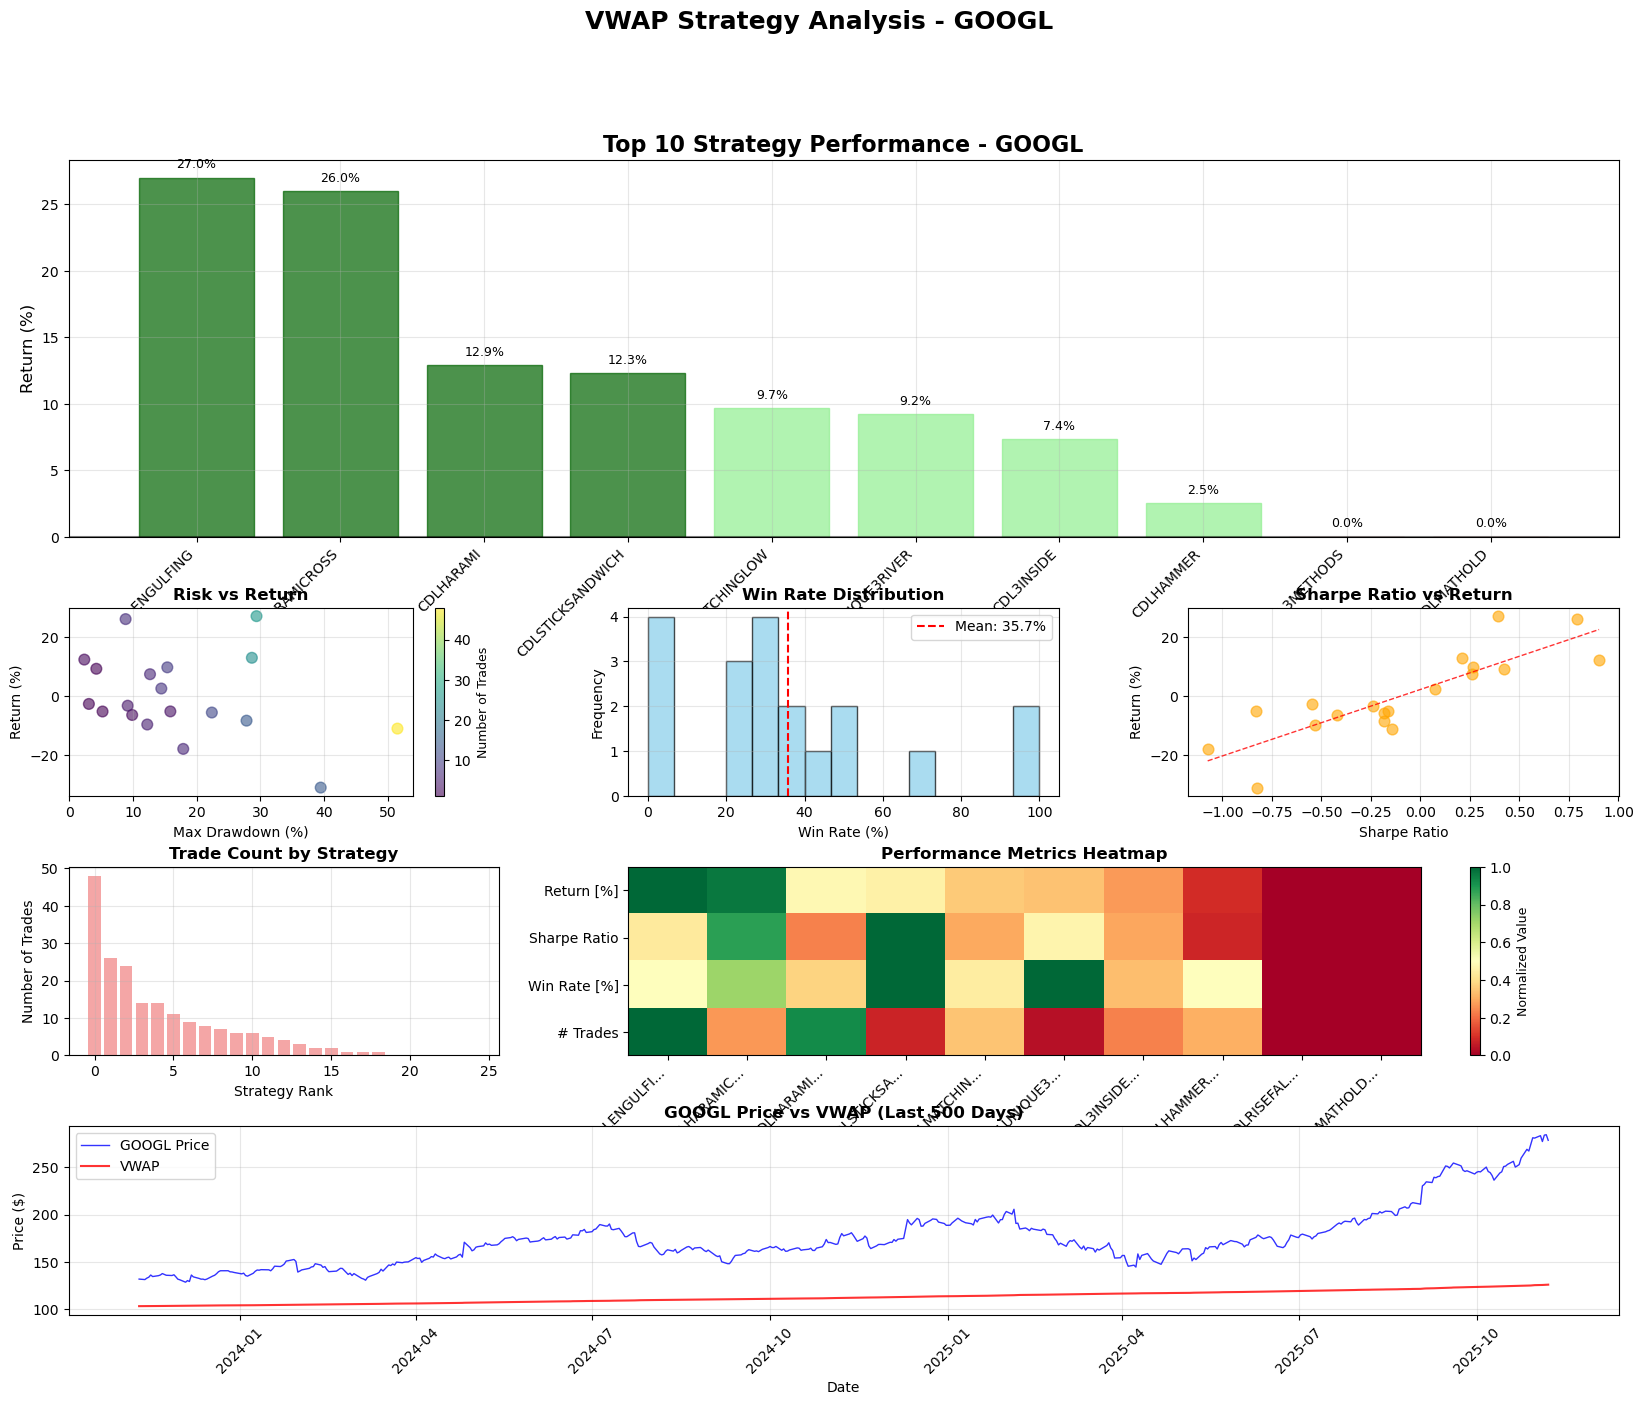

Comprehensive plots created successfully!


In [375]:
def create_comprehensive_plots(results_df: pd.DataFrame, data: pd.DataFrame, 
                              ticker_name: str) -> None:
    """
    Create comprehensive performance visualization plots
    """
    if len(results_df) == 0:
        print("No results to plot")
        return
    
    # Check available columns and create mapping
    available_columns = results_df.columns.tolist()
    print(f"Available columns for plotting: {available_columns}")
    
    # Define column mappings with alternatives
    column_mapping = {
        'Max Drawdown [%]': ['Max Drawdown [%]', 'Max. Drawdown [%]', 'MaxDrawdown [%]', 'Max Drawdown'],
        'Win Rate [%]': ['Win Rate [%]', 'Win Rate', 'WinRate [%]'],
        'Sharpe Ratio': ['Sharpe Ratio', 'SharpeRatio'],
        'Return [%]': ['Return [%]'],
        '# Trades': ['# Trades']
    }
    
    # Find actual column names
    actual_columns = {}
    for desired, alternatives in column_mapping.items():
        found = False
        for alt in alternatives:
            if alt in available_columns:
                actual_columns[desired] = alt
                found = True
                break
        if not found:
            print(f"Warning: Column '{desired}' not found, skipping related plots")
            actual_columns[desired] = None
    
    # Set up the plotting environment
    plt.rcParams['figure.figsize'] = (15, 10)
    plt.rcParams['font.size'] = 10
    
    # Create main figure with subplots
    fig = plt.figure(figsize=(20, 15))
    gs = fig.add_gridspec(4, 3, height_ratios=[2, 1, 1, 1], hspace=0.3, wspace=0.3)
    
    # 1. Strategy Performance Comparison
    ax1 = fig.add_subplot(gs[0, :])
    
    # Get top 10 strategies for plotting
    if actual_columns['Return [%]']:
        top_strategies = results_df.nlargest(10, actual_columns['Return [%]'])
        
        # Create bar plot of returns
        bars = ax1.bar(range(len(top_strategies)), top_strategies[actual_columns['Return [%]']], 
                       color='steelblue', alpha=0.7)
        
        # Color bars based on performance
        for i, bar in enumerate(bars):
            returns = top_strategies.iloc[i][actual_columns['Return [%]']]
            if returns > 10:
                bar.set_color('darkgreen')
            elif returns > 0:
                bar.set_color('lightgreen')
            else:
                bar.set_color('lightcoral')
        
        ax1.set_title(f'Top 10 Strategy Performance - {ticker_name}', fontsize=16, fontweight='bold')
        ax1.set_ylabel('Return (%)', fontsize=12)
        ax1.set_xlabel('Strategy', fontsize=12)
        ax1.set_xticks(range(len(top_strategies)))
        ax1.set_xticklabels([name.replace('VWAP_', '') for name in top_strategies['strategy_name']], 
                           rotation=45, ha='right')
        ax1.grid(True, alpha=0.3)
        ax1.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        
        # Add value labels on bars
        for i, bar in enumerate(bars):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontsize=9)
    else:
        ax1.text(0.5, 0.5, 'Return data not available', ha='center', va='center', 
                transform=ax1.transAxes, fontsize=14)
        ax1.set_title('Strategy Performance - Data Not Available', fontsize=16)
    
    # 2. Risk-Return Scatter Plot
    ax2 = fig.add_subplot(gs[1, 0])
    
    if actual_columns['Return [%]'] and actual_columns['Max Drawdown [%]']:
        # Filter out invalid values for scatter plot
        valid_data = results_df[
            (results_df[actual_columns['Return [%]']].notna()) & 
            (results_df[actual_columns['Max Drawdown [%]']].notna()) &
            (results_df[actual_columns['Max Drawdown [%]']] != 0)
        ].copy()
        
        if len(valid_data) > 0:
            scatter = ax2.scatter(valid_data[actual_columns['Max Drawdown [%]']].abs(), 
                                valid_data[actual_columns['Return [%]']],
                                c=valid_data[actual_columns['# Trades']] if actual_columns['# Trades'] else range(len(valid_data)), 
                                cmap='viridis', alpha=0.6, s=60)
            
            ax2.set_xlabel('Max Drawdown (%)', fontsize=10)
            ax2.set_ylabel('Return (%)', fontsize=10)
            ax2.set_title('Risk vs Return', fontsize=12, fontweight='bold')
            ax2.grid(True, alpha=0.3)
            
            # Add colorbar
            cbar = plt.colorbar(scatter, ax=ax2)
            cbar.set_label('Number of Trades' if actual_columns['# Trades'] else 'Index', fontsize=9)
        else:
            ax2.text(0.5, 0.5, 'No valid data for scatter plot', ha='center', va='center', 
                    transform=ax2.transAxes, fontsize=12)
    else:
        ax2.text(0.5, 0.5, 'Risk-Return data not available', ha='center', va='center', 
                transform=ax2.transAxes, fontsize=12)
    
    ax2.set_title('Risk vs Return', fontsize=12, fontweight='bold')
    
    # 3. Win Rate Distribution
    ax3 = fig.add_subplot(gs[1, 1])
    
    if actual_columns['Win Rate [%]']:
        win_rates = results_df[actual_columns['Win Rate [%]']].dropna()
        if len(win_rates) > 0:
            ax3.hist(win_rates, bins=15, alpha=0.7, color='skyblue', edgecolor='black')
            ax3.axvline(win_rates.mean(), color='red', linestyle='--', 
                       label=f'Mean: {win_rates.mean():.1f}%')
            ax3.set_xlabel('Win Rate (%)', fontsize=10)
            ax3.set_ylabel('Frequency', fontsize=10)
            ax3.set_title('Win Rate Distribution', fontsize=12, fontweight='bold')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
        else:
            ax3.text(0.5, 0.5, 'No win rate data', ha='center', va='center', 
                    transform=ax3.transAxes, fontsize=12)
    else:
        ax3.text(0.5, 0.5, 'Win Rate data not available', ha='center', va='center', 
                transform=ax3.transAxes, fontsize=12)
    
    ax3.set_title('Win Rate Distribution', fontsize=12, fontweight='bold')
    
    # 4. Sharpe Ratio vs Return
    ax4 = fig.add_subplot(gs[1, 2])
    
    if actual_columns['Sharpe Ratio'] and actual_columns['Return [%]']:
        sharpe_data = results_df[
            (results_df[actual_columns['Sharpe Ratio']].notna()) & 
            (results_df[actual_columns['Return [%]']].notna())
        ].copy()
        
        if len(sharpe_data) > 0:
            ax4.scatter(sharpe_data[actual_columns['Sharpe Ratio']], sharpe_data[actual_columns['Return [%]']], 
                       alpha=0.6, color='orange', s=60)
            ax4.set_xlabel('Sharpe Ratio', fontsize=10)
            ax4.set_ylabel('Return (%)', fontsize=10)
            ax4.set_title('Sharpe Ratio vs Return', fontsize=12, fontweight='bold')
            ax4.grid(True, alpha=0.3)
            
            # Add trend line
            if len(sharpe_data) > 1:
                z = np.polyfit(sharpe_data[actual_columns['Sharpe Ratio']], sharpe_data[actual_columns['Return [%]']], 1)
                p = np.poly1d(z)
                ax4.plot(sharpe_data[actual_columns['Sharpe Ratio']].sort_values(), 
                        p(sharpe_data[actual_columns['Sharpe Ratio']].sort_values()), 
                        "r--", alpha=0.8, linewidth=1)
        else:
            ax4.text(0.5, 0.5, 'No valid Sharpe data', ha='center', va='center', 
                    transform=ax4.transAxes, fontsize=12)
    else:
        ax4.text(0.5, 0.5, 'Sharpe Ratio data not available', ha='center', va='center', 
                transform=ax4.transAxes, fontsize=12)
    
    ax4.set_title('Sharpe Ratio vs Return', fontsize=12, fontweight='bold')
    
    # 5. Trade Count Analysis
    ax5 = fig.add_subplot(gs[2, 0])
    
    if actual_columns['# Trades']:
        trade_counts = results_df[actual_columns['# Trades']].dropna()
        if len(trade_counts) > 0:
            ax5.bar(range(len(trade_counts)), sorted(trade_counts, reverse=True), 
                   color='lightcoral', alpha=0.7)
            ax5.set_xlabel('Strategy Rank', fontsize=10)
            ax5.set_ylabel('Number of Trades', fontsize=10)
            ax5.set_title('Trade Count by Strategy', fontsize=12, fontweight='bold')
            ax5.grid(True, alpha=0.3)
        else:
            ax5.text(0.5, 0.5, 'No trade count data', ha='center', va='center', 
                    transform=ax5.transAxes, fontsize=12)
    else:
        ax5.text(0.5, 0.5, 'Trade count data not available', ha='center', va='center', 
                transform=ax5.transAxes, fontsize=12)
    
    ax5.set_title('Trade Count by Strategy', fontsize=12, fontweight='bold')
    
    # 6. Performance Metrics Heatmap
    ax6 = fig.add_subplot(gs[2, 1:])
    
    # Select available metrics for heatmap
    available_metrics = [col for col in [actual_columns['Return [%]'], actual_columns['Sharpe Ratio'], 
                                       actual_columns['Win Rate [%]'], actual_columns['# Trades']] if col]
    
    if len(available_metrics) > 0:
        # Get top 10 strategies with strategy names
        top_10_strategies = results_df.nlargest(10, actual_columns['Return [%]'])
        heatmap_data = top_10_strategies[available_metrics]
        
        if len(heatmap_data) > 0:
            # Normalize data for better visualization
            heatmap_normalized = heatmap_data.copy()
            for col in available_metrics:
                col_data = heatmap_normalized[col].fillna(0)
                if col_data.std() != 0:
                    heatmap_normalized[col] = (col_data - col_data.min()) / (col_data.max() - col_data.min())
            
            im = ax6.imshow(heatmap_normalized.T, cmap='RdYlGn', aspect='auto')
            
            # Set ticks and labels using strategy names
            ax6.set_xticks(range(len(heatmap_data)))
            # Get strategy names from the top_10_strategies DataFrame
            strategy_names = top_10_strategies['strategy_name'].tolist()
            ax6.set_xticklabels([name.replace('VWAP_', '')[:10] + '...' if len(name) > 13 else name.replace('VWAP_', '') 
                               for name in strategy_names], rotation=45, ha='right')
            ax6.set_yticks(range(len(available_metrics)))
            ax6.set_yticklabels(available_metrics)
            ax6.set_title('Performance Metrics Heatmap (Normalized)', fontsize=12, fontweight='bold')
            
            # Add colorbar
            cbar = plt.colorbar(im, ax=ax6)
            cbar.set_label('Normalized Value', fontsize=9)
        else:
            ax6.text(0.5, 0.5, 'No heatmap data available', ha='center', va='center', 
                    transform=ax6.transAxes, fontsize=12)
    else:
        ax6.text(0.5, 0.5, 'No metrics available for heatmap', ha='center', va='center', 
                transform=ax6.transAxes, fontsize=12)
    
    ax6.set_title('Performance Metrics Heatmap', fontsize=12, fontweight='bold')
    
    # 7. Price Chart with VWAP
    ax7 = fig.add_subplot(gs[3, :])
    
    # Calculate VWAP if not present
    data_for_plot = data.copy()
    if 'vwap' not in data_for_plot.columns:
        data_for_plot['vwap'] = calculate_vwap(data_for_plot)
    
    # Plot price and VWAP for context
    recent_data = data_for_plot.tail(500)  # Last 500 days
    ax7.plot(recent_data.index, recent_data['close'], label=f'{ticker_name} Price', 
            color='blue', linewidth=1, alpha=0.8)
    
    if 'vwap' in recent_data.columns and recent_data['vwap'].notna().any():
        ax7.plot(recent_data.index, recent_data['vwap'], label='VWAP', 
                color='red', linewidth=1.5, alpha=0.8)
    
    ax7.set_title(f'{ticker_name} Price vs VWAP (Last 500 Days)', fontsize=12, fontweight='bold')
    ax7.set_ylabel('Price ($)', fontsize=10)
    ax7.set_xlabel('Date', fontsize=10)
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Format x-axis dates
    ax7.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    ax7.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    plt.setp(ax7.xaxis.get_majorticklabels(), rotation=45)
    
    plt.suptitle(f'VWAP Strategy Analysis - {ticker_name}', fontsize=18, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()
    
    print("Comprehensive plots created successfully!")

# Create plots for training results
if len(train_results) > 0:
    print("Creating comprehensive performance plots...")
    create_comprehensive_plots(train_results, df_clean, ticker_name)
else:
    print("No successful backtest results to plot")

In [376]:
"""
VWap plot on ticker_name price chart looks incorrect, red line is not matching vwap values.
Need to review the VWAP calculation and plotting logic to ensure accuracy.
""";

Creating detailed analysis for best strategy: VWAP_CDLENGULFING


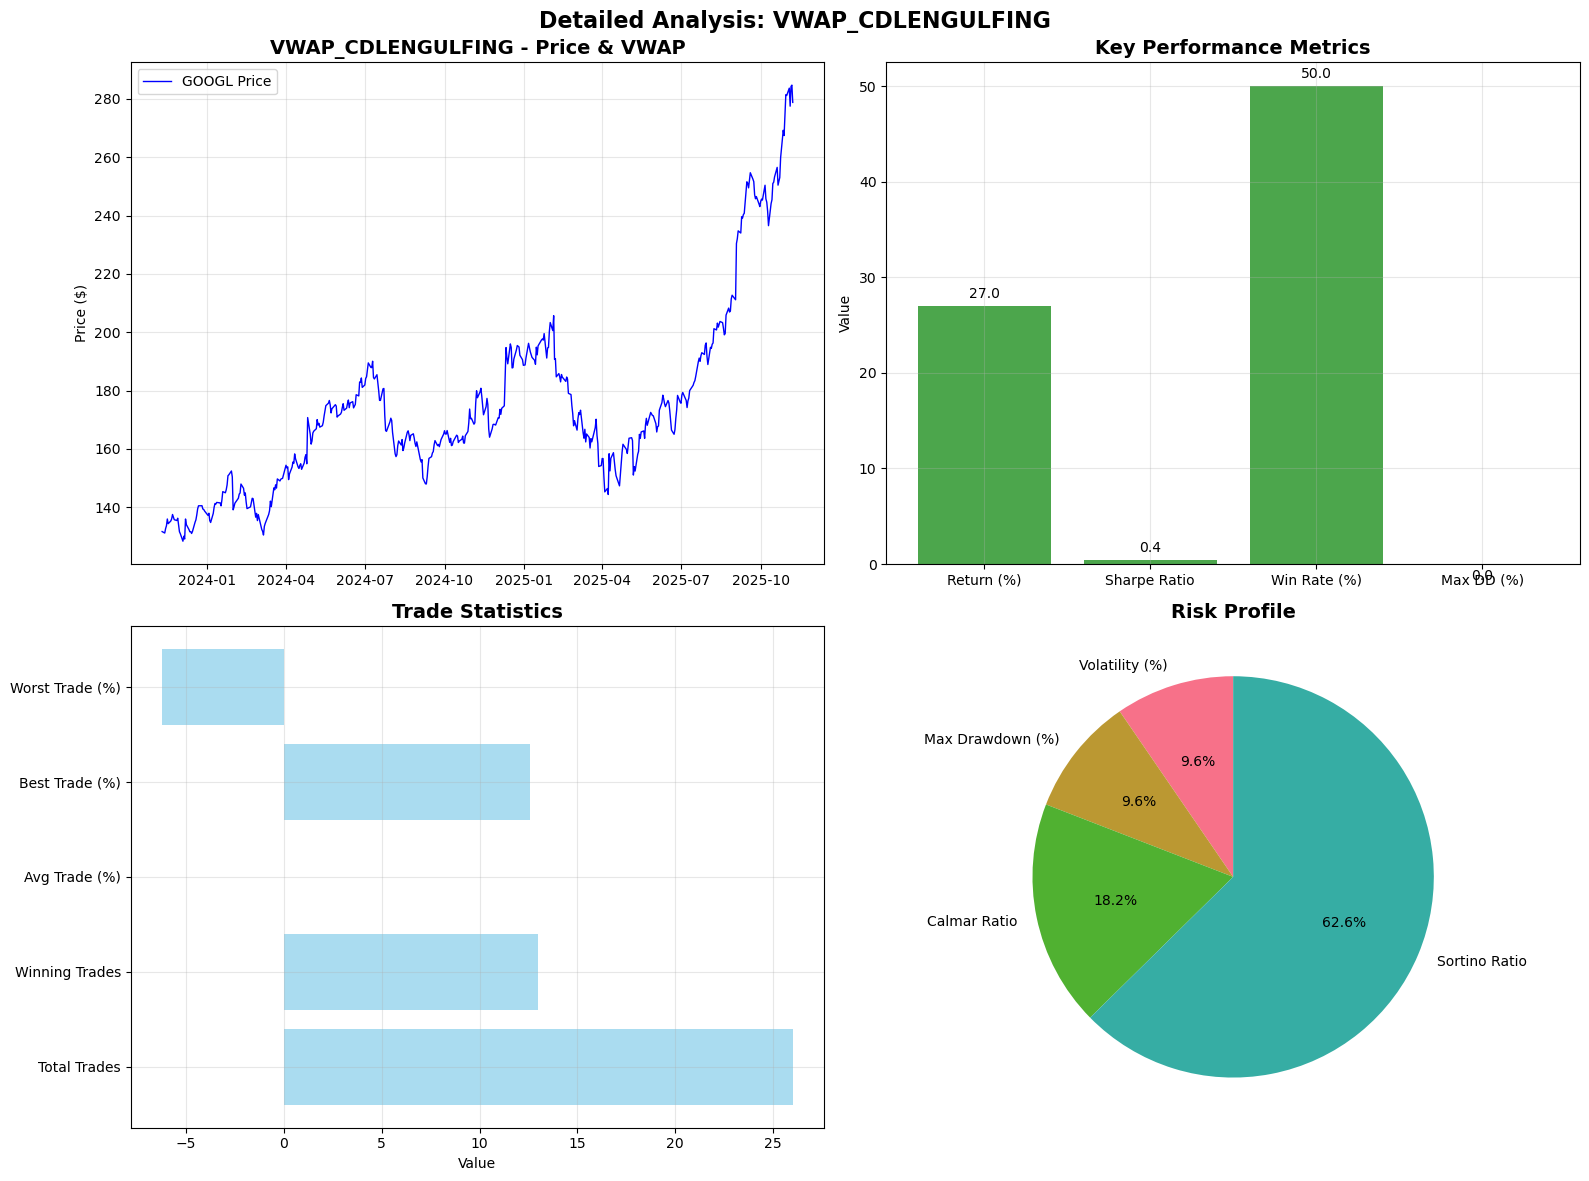

In [377]:
def plot_individual_strategy_performance(strategy_result: Dict, data: pd.DataFrame, 
                                       ticker_name: str) -> None:
    """
    Plot detailed performance for a single strategy
    """
    if not strategy_result.get('success', False):
        print("Cannot plot failed strategy")
        return
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
    
    # Get the backtest object to access detailed results
    bt = strategy_result.get('backtest_object')
    strategy_name = strategy_result.get('strategy_name', 'Unknown')
    
    # 1. Price chart with entry/exit points (if backtest object available)
    recent_data = data.tail(500)
    ax1.plot(recent_data.index, recent_data['close'], label=f'{ticker_name} Price', 
            color='blue', linewidth=1)
    
    if 'vwap' in recent_data.columns:
        ax1.plot(recent_data.index, recent_data['vwap'], label='VWAP', 
                color='red', linewidth=1.5, alpha=0.7)
    
    ax1.set_title(f'{strategy_name} - Price & VWAP', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 2. Performance metrics bar chart
    metrics = {
        'Return (%)': strategy_result.get('Return [%]', 0),
        'Sharpe Ratio': strategy_result.get('Sharpe Ratio', 0),
        'Win Rate (%)': strategy_result.get('Win Rate [%]', 0),
        'Max DD (%)': -abs(strategy_result.get('Max Drawdown [%]', 0))
    }
    
    colors = ['green' if v > 0 else 'red' for v in metrics.values()]
    bars = ax2.bar(metrics.keys(), metrics.values(), color=colors, alpha=0.7)
    ax2.set_title('Key Performance Metrics', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Value')
    ax2.grid(True, alpha=0.3)
    
    # Add value labels
    for bar, value in zip(bars, metrics.values()):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + (0.5 if height > 0 else -0.5),
                f'{value:.1f}', ha='center', va='bottom' if height > 0 else 'top')
    
    # 3. Trade statistics
    trade_stats = {
        'Total Trades': strategy_result.get('# Trades', 0),
        'Winning Trades': int(strategy_result.get('# Trades', 0) * strategy_result.get('Win Rate [%]', 0) / 100),
        'Avg Trade (%)': strategy_result.get('Avg Trade [%]', 0),
        'Best Trade (%)': strategy_result.get('Best Trade [%]', 0),
        'Worst Trade (%)': strategy_result.get('Worst Trade [%]', 0)
    }
    
    ax3.barh(list(trade_stats.keys()), list(trade_stats.values()), color='skyblue', alpha=0.7)
    ax3.set_title('Trade Statistics', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Value')
    ax3.grid(True, alpha=0.3)
    
    # 4. Risk metrics
    risk_metrics = {
        'Volatility (%)': strategy_result.get('Volatility (ann.) [%]', 0),
        'Max Drawdown (%)': abs(strategy_result.get('Max Drawdown [%]', 0)),
        'Calmar Ratio': strategy_result.get('Calmar Ratio', 0) if strategy_result.get('Calmar Ratio') not in ['N/A', None] else 0,
        'Sortino Ratio': strategy_result.get('Sortino Ratio', 0) if strategy_result.get('Sortino Ratio') not in ['N/A', None] else 0
    }
    
    ax4.pie([max(0.1, abs(v)) for v in risk_metrics.values()], 
           labels=risk_metrics.keys(), autopct='%1.1f%%', startangle=90)
    ax4.set_title('Risk Profile', fontsize=14, fontweight='bold')
    
    plt.suptitle(f'Detailed Analysis: {strategy_name}', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Plot detailed analysis for best strategy
if len(train_results) > 0:
    best_strategy = train_results.loc[train_results['Return [%]'].idxmax()].to_dict()
    print(f"Creating detailed analysis for best strategy: {best_strategy['strategy_name']}")
    plot_individual_strategy_performance(best_strategy, df_clean, ticker_name)

## 11. Monte Carlo Simulation and Robustness Testing

In [378]:
def generate_synthetic_ohlc_data(original_data: pd.DataFrame, n_periods: int = None) -> pd.DataFrame:
    """
    Generate synthetic OHLC data based on original data statistics
    - REMOVED fixed seed for true randomness in Monte Carlo
    """
    if n_periods is None:
        n_periods = len(original_data)
    
    # Calculate returns and volatilities from original data
    returns = original_data['close'].pct_change().dropna()
    vol_returns = original_data['volume'].pct_change().dropna()
    
    # Get statistical properties
    mean_return = returns.mean()
    std_return = returns.std()
    mean_vol_return = vol_returns.mean()
    std_vol_return = vol_returns.std()
    
    # Generate random returns - NO FIXED SEED for true randomness
    # np.random.seed(42)  # REMOVED - let it be truly random
    random_returns = np.random.normal(mean_return, std_return, n_periods)
    random_vol_returns = np.random.normal(mean_vol_return, std_vol_return, n_periods)
    
    # Start with initial values from original data
    initial_close = original_data['close'].iloc[0]
    initial_volume = original_data['volume'].iloc[0]
    
    # Generate synthetic price series
    synthetic_close = [initial_close]
    synthetic_volume = [initial_volume]
    
    for i in range(n_periods - 1):
        new_close = synthetic_close[-1] * (1 + random_returns[i])
        new_volume = max(100, synthetic_volume[-1] * (1 + random_vol_returns[i]))  # Ensure positive volume
        synthetic_close.append(new_close)
        synthetic_volume.append(new_volume)
    
    # Generate OHLC from close prices
    synthetic_data = []
    for i in range(len(synthetic_close)):
        close = synthetic_close[i]
        # Generate realistic OHLC based on close price with some randomness
        daily_range = abs(np.random.normal(0, close * 0.02))  # 2% average daily range
        
        high = close + np.random.uniform(0, daily_range)
        low = close - np.random.uniform(0, daily_range)
        
        # Ensure open is between high and low
        open_price = np.random.uniform(low, high)
        
        synthetic_data.append({
            'Open': open_price,
            'High': high,
            'Low': low,
            'Close': close,
            'Volume': synthetic_volume[i]
        })
    
    return pd.DataFrame(synthetic_data)

def run_monte_carlo_simulation(strategy_config: Dict, original_data: pd.DataFrame, 
                              n_simulations: int = 100) -> Dict:
    """
    Run Monte Carlo simulation for strategy robustness testing
    - REMOVED random_seed parameter for true randomness
    - Each run will produce different results for proper robustness testing
    """
    # NO FIXED SEEDS - let it be truly random for proper Monte Carlo
    # np.random.seed(random_seed)  # REMOVED
    # random.seed(random_seed)     # REMOVED
    
    print(f"Running Monte Carlo simulation for {strategy_config['name']} ({n_simulations} runs)...")
    print(f"Note: Results will vary between runs for proper robustness testing")
    
    results = []
    n_periods = min(len(original_data), 500)  # Use up to 500 periods for efficiency
    
    for i in range(n_simulations):
        try:
            # NO FIXED SEEDS - each simulation gets truly random data
            # np.random.seed(random_seed + i)  # REMOVED
            # random.seed(random_seed + i)     # REMOVED
            
            # Generate synthetic OHLC data (will be different each time)
            synthetic_data = generate_synthetic_ohlc_data(original_data, n_periods)
            
            # Run backtest on synthetic data
            result = run_single_backtest(strategy_config, synthetic_data)
            
            if result['success']:
                results.append({
                    'simulation': i + 1,
                    'return': result.get('Return [%]', 0),
                    'sharpe': result.get('Sharpe Ratio', 0),
                    'max_dd': result.get('Max Drawdown [%]', 0),
                    'trades': result.get('# Trades', 0),
                    'win_rate': result.get('Win Rate [%]', 0)
                })
            
            if (i + 1) % 20 == 0:
                print(f"  Completed {i + 1}/{n_simulations} simulations...")
                
        except Exception as e:
            # Skip failed simulations
            continue
    
    if len(results) == 0:
        return {'success': False, 'error': 'No successful simulations'}
    
    # Calculate statistics
    returns = [r['return'] for r in results]
    sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe']) and r['sharpe'] != 0]
    
    mc_stats = {
        'success': True,
        'n_successful_sims': len(results),
        'return_stats': {
            'mean': np.mean(returns),
            'std': np.std(returns),
            'min': np.min(returns),
            'max': np.max(returns),
            'percentile_5': np.percentile(returns, 5),
            'percentile_95': np.percentile(returns, 95)
        },
        'sharpe_stats': {
            'mean': np.mean(sharpes) if sharpes else 0,
            'std': np.std(sharpes) if sharpes else 0,
        },
        'positive_return_probability': len([r for r in returns if r > 0]) / len(returns),
        'raw_results': results
    }
    
    print(f"Monte Carlo completed: {len(results)} successful simulations")
    print(f"Mean return: {mc_stats['return_stats']['mean']:.2f}% ± {mc_stats['return_stats']['std']:.2f}%")
    print(f"Positive return probability: {mc_stats['positive_return_probability']:.2%}")
    print(f"Return range: {mc_stats['return_stats']['min']:.2f}% to {mc_stats['return_stats']['max']:.2f}%")
    
    return mc_stats

# Updated function call (removed random_seed parameter)
if len(train_results) > 0:
    best_strategy_name = train_results.loc[train_results['Return [%]'].idxmax(), 'strategy_name']
    best_config = next(
        (config for config in strategy_configs if config['name'] == best_strategy_name),
        None
    )
    
    if best_config:
        # Prepare data in correct format for Monte Carlo
        mc_data = df_clean[['open', 'high', 'low', 'close', 'volume']].copy()
        
        print(f"Starting Monte Carlo simulation for best strategy: {best_strategy_name}")
        print("Note: Each run will produce different results for proper robustness testing")
        
        # Run multiple Monte Carlo tests to see variation
        print("\n=== Running 3 Monte Carlo tests to demonstrate variation ===")
        for test_run in range(3):
            print(f"\nMonte Carlo Test Run #{test_run + 1}:")
            mc_results = run_monte_carlo_simulation(best_config, mc_data, n_simulations=50)
            
            if mc_results.get('success', False):
                print(f"  Mean Return: {mc_results['return_stats']['mean']:.2f}%")
                print(f"  Std Dev: {mc_results['return_stats']['std']:.2f}%")
                print(f"  Win Probability: {mc_results['positive_return_probability']:.2%}")
            else:
                print(f"  Test run failed: {mc_results.get('error', 'Unknown error')}")
else:
    print("No strategies available for Monte Carlo simulation")

Starting Monte Carlo simulation for best strategy: VWAP_CDLENGULFING
Note: Each run will produce different results for proper robustness testing

=== Running 3 Monte Carlo tests to demonstrate variation ===

Monte Carlo Test Run #1:
Running Monte Carlo simulation for VWAP_CDLENGULFING (50 runs)...
Note: Results will vary between runs for proper robustness testing
  Completed 20/50 simulations...
  Completed 40/50 simulations...
Monte Carlo completed: 50 successful simulations
Mean return: 1.69% ± 12.04%
Positive return probability: 36.00%
Return range: -26.95% to 31.52%
  Mean Return: 1.69%
  Std Dev: 12.04%
  Win Probability: 36.00%

Monte Carlo Test Run #2:
Running Monte Carlo simulation for VWAP_CDLENGULFING (50 runs)...
Note: Results will vary between runs for proper robustness testing
  Completed 20/50 simulations...
  Completed 40/50 simulations...
Monte Carlo completed: 50 successful simulations
Mean return: 1.05% ± 12.42%
Positive return probability: 48.00%
Return range: -19.57

In [379]:
# check again def plot_monte_carlo_results(mc_results: Dict, strategy_name: str) -> None:
# not included anymore in cell 33
# take from cell 35

In [380]:
# def generate_synthetic_ohlc_data(original_data: pd.DataFrame, n_periods: int = None) -> pd.DataFrame:
#     """
#     Generate synthetic OHLC data based on original data statistics
#     """
#     if n_periods is None:
#         n_periods = len(original_data)
    
#     # Calculate returns and volatilities from original data
#     returns = original_data['close'].pct_change().dropna()
#     vol_returns = original_data['volume'].pct_change().dropna()
    
#     # Get statistical properties
#     mean_return = returns.mean()
#     std_return = returns.std()
#     mean_vol_return = vol_returns.mean()
#     std_vol_return = vol_returns.std()
    
#     # Generate random returns
#     np.random.seed(42)
#     random_returns = np.random.normal(mean_return, std_return, n_periods)
#     random_vol_returns = np.random.normal(mean_vol_return, std_vol_return, n_periods)
    
#     # Start with initial values from original data
#     initial_close = original_data['close'].iloc[0]
#     initial_volume = original_data['volume'].iloc[0]
    
#     # Generate synthetic price series
#     synthetic_close = [initial_close]
#     synthetic_volume = [initial_volume]
    
#     for i in range(n_periods - 1):
#         new_close = synthetic_close[-1] * (1 + random_returns[i])
#         new_volume = max(100, synthetic_volume[-1] * (1 + random_vol_returns[i]))  # Ensure positive volume
#         synthetic_close.append(new_close)
#         synthetic_volume.append(new_volume)
    
#     # Generate OHLC from close prices
#     synthetic_data = []
#     for i in range(len(synthetic_close)):
#         close = synthetic_close[i]
#         # Generate realistic OHLC based on close price with some randomness
#         daily_range = abs(np.random.normal(0, close * 0.02))  # 2% average daily range
        
#         high = close + np.random.uniform(0, daily_range)
#         low = close - np.random.uniform(0, daily_range)
        
#         # Ensure open is between high and low
#         open_price = np.random.uniform(low, high)
        
#         synthetic_data.append({
#             'Open': open_price,
#             'High': high,
#             'Low': low,
#             'Close': close,
#             'Volume': synthetic_volume[i]
#         })
    
#     return pd.DataFrame(synthetic_data)

# def run_monte_carlo_simulation(strategy_config: Dict, original_data: pd.DataFrame, 
#                               n_simulations: int = 100, random_seed: int = 42) -> Dict:
#     """
#     Run Monte Carlo simulation for strategy robustness testing
#     """
#     np.random.seed(random_seed)
#     random.seed(random_seed)
    
#     print(f"Running Monte Carlo simulation for {strategy_config['name']} ({n_simulations} runs)...")
    
#     results = []
#     n_periods = min(len(original_data), 500)  # Use up to 500 periods for efficiency
    
#     for i in range(n_simulations):
#         try:
#             # Generate synthetic data with different seed for each simulation
#             np.random.seed(random_seed + i)
#             random.seed(random_seed + i)
            
#             # Generate synthetic OHLC data
#             synthetic_data = generate_synthetic_ohlc_data(original_data, n_periods)
            
#             # Run backtest on synthetic data
#             result = run_single_backtest(strategy_config, synthetic_data)
            
#             if result['success']:
#                 results.append({
#                     'simulation': i + 1,
#                     'return': result.get('Return [%]', 0),
#                     'sharpe': result.get('Sharpe Ratio', 0),
#                     'max_dd': result.get('Max Drawdown [%]', 0),
#                     'trades': result.get('# Trades', 0),
#                     'win_rate': result.get('Win Rate [%]', 0)
#                 })
            
#             if (i + 1) % 20 == 0:
#                 print(f"  Completed {i + 1}/{n_simulations} simulations...")
                
#         except Exception as e:
#             # Skip failed simulations
#             continue
    
#     if len(results) == 0:
#         return {'success': False, 'error': 'No successful simulations'}
    
#     # Calculate statistics
#     returns = [r['return'] for r in results]
#     sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe']) and r['sharpe'] != 0]
    
#     mc_stats = {
#         'success': True,
#         'n_successful_sims': len(results),
#         'return_stats': {
#             'mean': np.mean(returns),
#             'std': np.std(returns),
#             'min': np.min(returns),
#             'max': np.max(returns),
#             'percentile_5': np.percentile(returns, 5),
#             'percentile_95': np.percentile(returns, 95)
#         },
#         'sharpe_stats': {
#             'mean': np.mean(sharpes) if sharpes else 0,
#             'std': np.std(sharpes) if sharpes else 0,
#         },
#         'positive_return_probability': len([r for r in returns if r > 0]) / len(returns),
#         'raw_results': results
#     }
    
#     print(f"Monte Carlo completed: {len(results)} successful simulations")
#     print(f"Mean return: {mc_stats['return_stats']['mean']:.2f}% ± {mc_stats['return_stats']['std']:.2f}%")
#     print(f"Positive return probability: {mc_stats['positive_return_probability']:.2%}")
    
#     return mc_stats

# def plot_monte_carlo_results(mc_results: Dict, strategy_name: str) -> None:
#     """
#     Plot Monte Carlo simulation results
#     """
#     if not mc_results.get('success', False):
#         print("No Monte Carlo results to plot")
#         return
    
#     fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
    
#     results = mc_results['raw_results']
#     returns = [r['return'] for r in results]
#     sharpes = [r['sharpe'] for r in results if not pd.isna(r['sharpe']) and r['sharpe'] != 0]
    
#     # 1. Return distribution
#     ax1.hist(returns, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
#     ax1.axvline(np.mean(returns), color='red', linestyle='--', 
#                label=f'Mean: {np.mean(returns):.2f}%')
#     ax1.axvline(0, color='black', linestyle='-', alpha=0.5)
#     ax1.set_xlabel('Return (%)')
#     ax1.set_ylabel('Frequency')
#     ax1.set_title('Monte Carlo Return Distribution')
#     ax1.legend()
#     ax1.grid(True, alpha=0.3)
    
#     # 2. Cumulative return probability
#     sorted_returns = np.sort(returns)
#     cumprob = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)
    
#     ax2.plot(sorted_returns, cumprob, color='green', linewidth=2)
#     ax2.axvline(0, color='red', linestyle='--', alpha=0.7, label='Break-even')
#     ax2.set_xlabel('Return (%)')
#     ax2.set_ylabel('Cumulative Probability')
#     ax2.set_title('Cumulative Return Probability')
#     ax2.legend()
#     ax2.grid(True, alpha=0.3)
    
#     # 3. Sharpe ratio distribution (if available)
#     if sharpes and len(sharpes) > 1:
#         ax3.hist(sharpes, bins=20, alpha=0.7, color='orange', edgecolor='black')
#         ax3.axvline(np.mean(sharpes), color='red', linestyle='--',
#                    label=f'Mean: {np.mean(sharpes):.2f}')
#         ax3.set_xlabel('Sharpe Ratio')
#         ax3.set_ylabel('Frequency')
#         ax3.set_title('Sharpe Ratio Distribution')
#         ax3.legend()
#         ax3.grid(True, alpha=0.3)
#     else:
#         ax3.text(0.5, 0.5, 'Insufficient Sharpe Ratio Data', ha='center', va='center', 
#                 transform=ax3.transAxes, fontsize=14)
#         ax3.set_title('Sharpe Ratio Distribution')
    
#     # 4. Risk-return scatter
#     max_dds = [abs(r['max_dd']) for r in results]
#     ax4.scatter(max_dds, returns, alpha=0.6, color='purple')
#     ax4.set_xlabel('Max Drawdown (%)')
#     ax4.set_ylabel('Return (%)')
#     ax4.set_title('Risk vs Return')
#     ax4.grid(True, alpha=0.3)
    
#     plt.suptitle(f'Monte Carlo Analysis: {strategy_name}', fontsize=16, fontweight='bold')
#     plt.tight_layout()
#     plt.show()

# # Run Monte Carlo simulation on best strategy
# if len(train_results) > 0:
#     best_strategy_name = train_results.loc[train_results['Return [%]'].idxmax(), 'strategy_name']
#     best_config = next(
#         (config for config in strategy_configs if config['name'] == best_strategy_name),
#         None
#     )
    
#     if best_config:
#         # Prepare data in correct format for Monte Carlo
#         mc_data = df_clean[['open', 'high', 'low', 'close', 'volume']].copy()
        
#         print(f"Starting Monte Carlo simulation for best strategy: {best_strategy_name}")
#         mc_results = run_monte_carlo_simulation(best_config, mc_data, n_simulations=50)
        
#         if mc_results.get('success', False):
#             plot_monte_carlo_results(mc_results, best_strategy_name)
#         else:
#             print(f"Monte Carlo simulation failed: {mc_results.get('error', 'Unknown error')}")
# else:
#     print("No strategies available for Monte Carlo simulation")

## 12. Multi-Timeframe Analysis

### Preparing Data

In [381]:
"""
The following cells should be uncommented when running the full notebook end-to-end
""" 

'\nThe following cells should be uncommented when running the full notebook end-to-end\n'

In [382]:
# # old
# import yfinance as yf

# def download_data_1h(ticker_name, days_back=59, save_path=None):
#     """
#     Download 1-hour historical stock data from Yahoo Finance and save to CSV.
    
#     Parameters:
#     -----------
#     ticker_name : str
#         Single stock ticker symbol (e.g., 'AAPL', 'MSFT', 'NVDA')
#     days_back : int, default 59
#         Number of days back from current date to download
#     save_path : str, optional
#         Custom path to save CSV. If None, uses auto-generated name
    
#     Returns:
#     --------
#     pd.DataFrame
#         Downloaded 1-hour stock data with OHLCV columns
#     str
#         Path where the CSV file was saved
#     """
    
#     # Calculate date range
#     end_date = datetime.now()
#     # start_date = end_date - timedelta(days=days_back)
    
#     # Format dates for filename and API
#     end_date_str = end_date.strftime("%Y-%m-%d")
#     # start_date_str = start_date.strftime("%Y-%m-%d")
    
#     print(f"=== DOWNLOADING 1H DATA ===")
#     print(f"Ticker: {ticker_name}")
#     # print(f"Period: {start_date_str} to {end_date_str} ({days_back} days)")
    
#     try:
#         # Download 1-hour data from Yahoo Finance
#         # data = yf.download(
#         #     ticker_name, 
#         #     start=start_date_str, 
#         #     end=end_date_str, 
#         #     interval='1h',  # 1-hour intervals
#         #     progress=True   # Show download progress
#         # )
#         data = yf.download(
#             ticker_name, 
#             period="max",  # maximum available period
#             interval='1h',  # 1-hour intervals
#             auto_adjust=True,
#         )
        
#         print(f"Downloaded data shape: {data.shape}")
#         print(f"Downloaded columns: {data.columns.tolist()}")
        
#         if data.empty:
#             print(f"ERROR: No data retrieved for {ticker_name}")
#             return None, None
            
#     except Exception as e:
#         print(f"ERROR downloading data: {e}")
#         return None, None
    
#     # Generate filename if not provided
#     if save_path is None:
#         # filename = f"data_{ticker_name}_{start_date_str}_{end_date_str}_1h.csv"
#         filename = f"data_{ticker_name}_{end_date_str}_1h.csv"

#     else:
#         filename = save_path
    
#     # Get current working directory
#     current_dir = os.getcwd()
#     full_path = os.path.join(current_dir, filename)
    
#     try:
#         # Save to CSV
#         data.to_csv(filename)
#         print(f"SUCCESS: Data saved to: {full_path}")
        
#         # Verify file was created
#         if os.path.exists(filename):
#             file_size = os.path.getsize(filename)
#             print(f"SUCCESS: File verified - Size: {file_size:,} bytes")
#         else:
#             print(f"ERROR: File was not created: {filename}")
#             return data, None
            
#     except Exception as e:
#         print(f"ERROR saving file: {e}")
#         return data, None
    
#     print(f"Data info:")
#     print(f"   Shape: {data.shape}")
#     print(f"   Date range: {data.index.min()} to {data.index.max()}")
#     print(f"   Columns: {list(data.columns)}")
    
#     return data, filename

In [383]:
# new
import yfinance as yf

def download_data_1h(ticker_name, period="max", auto_adjust=True, interval="1h", save_path=None):
    """
    Download 1-hour historical stock data from Yahoo Finance and save to CSV.
    """
    print(f"=== DOWNLOADING 1H DATA for {ticker_name} ===")

    try:
        data = yf.download(ticker_name, period=period, interval=interval, auto_adjust=auto_adjust, progress=False)
        if data.empty:
            print("ERROR: No data retrieved.")
            return None, None
    except Exception as e:
        print(f"Download failed: {e}")
        return None, None

    # Build filename
    end_date_str = datetime.now().strftime("%Y-%m-%d")
    filename = save_path or f"data_{ticker_name}_{end_date_str}_1h.csv"
    full_path = os.path.join(os.getcwd(), filename)

    try:
        data.to_csv(full_path)
        print(f"Data saved")
    except Exception as e:
        print(f"Error saving CSV: {e}")
        return data, None

    print(f"Shape: {data.shape}, Range: {data.index.min()} → {data.index.max()}")
    return data, full_path


In [384]:
# # old
# def load_market_data_1h(ticker_name, days_back=59, force_download=False):
#     """
#     Load 1-hour market data for a ticker. Downloads if file doesn't exist or force_download=True.
    
#     Parameters:
#     -----------
#     ticker_name : str
#         Stock ticker symbol (e.g., 'AAPL', 'MSFT', 'NVDA')
#     days_back : int, default 59
#         Number of days back to load data for
#     force_download : bool, default False
#         If True, downloads fresh data even if file exists
    
#     Returns:
#     --------
#     pd.DataFrame
#         1-hour stock data with DatetimeIndex and OHLCV columns
#     """
    
#     # Calculate expected filename
#     end_date = datetime.now()
#     # start_date = end_date - timedelta(days=days_back)
#     end_date_str = end_date.strftime("%Y-%m-%d")
#     # start_date_str = start_date.strftime("%Y-%m-%d")
    
#     # filename = f"data_{ticker_name}_{start_date_str}_{end_date_str}_1h.csv"
#     filename = f"data_{ticker_name}_{end_date_str}_1h.csv"
    
#     print(f"=== LOADING 1H DATA ===")
#     print(f"Looking for file: {filename}")
#     print(f"Current directory: {os.getcwd()}")
    
#     # Check if file exists
#     file_exists = os.path.exists(filename)
#     print(f"File exists: {file_exists}")
    
#     if force_download or not file_exists:
#         print(f"Downloading fresh 1-hour data for {ticker_name}...")
#         df, saved_file = download_data_1h(ticker_name, period="max", auto_adjust=True, interval="1h")
        
#         if df is None:
#             print("ERROR: Failed to download data")
#             return None
            
#     else:
#         print(f"Loading existing 1-hour data from: {filename}")
#         try:
#             df = pd.read_csv(filename, index_col=0, parse_dates=True)
#             print(f"SUCCESS: File loaded successfully")
#         except Exception as e:
#             print(f"ERROR loading file: {e}")
#             print("Attempting to download fresh data...")
#             df, saved_file = download_data_1h(ticker_name, period="max", auto_adjust=True, interval="1h")
            
#             if df is None:
#                 return None
    
#     # Clean and validate data
#     df = df.dropna(how='all')  # Drop completely NaN rows
    
#     # Ensure proper column names
#     expected_columns = ['Open', 'High', 'Low', 'Close', 'Volume']
#     missing_cols = [col for col in expected_columns if col not in df.columns]
    
#     if missing_cols:
#         print(f"WARNING: Missing expected columns: {missing_cols}")
    
#     print(f"Final data info:")
#     print(f"   Shape: {df.shape}")
#     print(f"   Columns: {df.columns.tolist()}")
#     print(f"   Date range: {df.index.min()} to {df.index.max()}")
#     print(f"   Memory usage: {df.memory_usage(deep=True).sum():,} bytes")
    
#     return df

# # Test the functions
# print("Functions defined successfully!")
# # print("Ready to use download_data_1h() and load_market_data_1h()")

In [385]:
# new 
def load_market_data_1h(ticker_name, force_download=False):
    """
    Load 1-hour market data for a ticker.
    Downloads if CSV doesn't exist or force_download=True.
    """
    end_date_str = datetime.now().strftime("%Y-%m-%d")
    filename = f"data_{ticker_name}_{end_date_str}_1h.csv"

    if force_download or not os.path.exists(filename):
        print("Downloading fresh 1-hour data...")
        df, saved_file = download_data_1h(ticker_name)
        if df is None:
            return None
    else:
        print(f"Loading existing file: {filename}")
        df = pd.read_csv(filename, index_col=0, parse_dates=True)

    df = df.dropna(how='all')
    df.columns = [c.capitalize() for c in df.columns]

    print(f"Data loaded: {df.shape} rows, from {df.index.min()} to {df.index.max()}")
    return df


In [386]:
# # old
# # Test the download function
# # ticker_name = 'NVDA'
# print(f"Testing download for {ticker_name}...")

# df, saved_file = download_data_1h(ticker_name, period="max", auto_adjust=True, interval="1h")

# if df is not None:
#     print(f"\nSUCCESS! Downloaded 1-hour data")
#     print(f"File saved as: {saved_file}")
#     print(f"\nSample data:")
#     print(df.head(3))
#     print(f"\nLatest data:")
#     print(df.tail(2))
# else:
#     print("Download failed")

In [387]:
# new 
# === Test download ===
# ticker_name = "NVDA"
df, saved_file = download_data_1h(ticker_name)

if df is not None:
    print("\nSample data:")
    print(df.head(3))
else:
    print("Download failed.")


=== DOWNLOADING 1H DATA for GOOGL ===
Data saved
Shape: (3479, 5), Range: 2023-11-13 14:30:00+00:00 → 2025-11-10 19:30:00+00:00

Sample data:
Price                           Close        High         Low        Open  \
Ticker                          GOOGL       GOOGL       GOOGL       GOOGL   
Datetime                                                                    
2023-11-13 14:30:00+00:00  131.955002  132.240005  131.250000  131.779999   
2023-11-13 15:30:00+00:00  132.380005  132.410004  131.860001  131.949997   
2023-11-13 16:30:00+00:00  132.190002  132.490005  132.029999  132.369995   

Price                       Volume  
Ticker                       GOOGL  
Datetime                            
2023-11-13 14:30:00+00:00  4422677  
2023-11-13 15:30:00+00:00  2123729  
2023-11-13 16:30:00+00:00  1645342  


### Data Preprocessing

In [388]:
# # old
# # Test load function with the actual downloaded file
# # ticker_name = 'NVDA'
# print(f"Testing load function for {ticker_name}...")

# # Calculate the expected filename based on current date
# end_date = datetime.now()
# # start_date = end_date - timedelta(days=59)
# end_date_str = end_date.strftime("%Y-%m-%d")
# # start_date_str = start_date.strftime("%Y-%m-%d")

# # Construct the actual filename
# # filename = f"data_{ticker_name}_{start_date_str}_{end_date_str}_1h.csv"
# filename = f"data_{ticker_name}_{end_date_str}_1h.csv"

# print(f"Looking for file: {filename}")
# print(f"File exists: {os.path.exists(filename)}")

# if os.path.exists(filename):
#     try:
#         # Read CSV with proper MultiIndex handling
#         df_loaded = pd.read_csv(filename, header=[0,1], index_col=0)
        
#         # Drop any rows that are completely NaN (e.g. 'Date' row)
#         df_loaded = df_loaded.dropna(how='all')
        
#         # Handle yfinance MultiIndex columns properly
#         if isinstance(df_loaded.columns, pd.MultiIndex):
#             print("Detected MultiIndex columns")
#             print(f"Column levels: {df_loaded.columns.names}")
#             print(f"Sample columns: {df_loaded.columns[:3].tolist()}")
            
#             # For yfinance data, we want the first level (OHLCV names), not the ticker level
#             # Get the first level which should be ['Open', 'High', 'Low', 'Close', 'Volume']
#             df_loaded.columns = [col[0].lower() for col in df_loaded.columns.values]
#         else:
#             # Regular columns - just convert to lowercase
#             df_loaded.columns = df_loaded.columns.str.lower()
        
#         # Convert all values to float
#         df_loaded = df_loaded.astype(float)
        
#         print(f"Selected data for {ticker_name}")
#         print(f"Date range: {df_loaded.index.min()} to {df_loaded.index.max()}")
#         print(f"Shape: {df_loaded.shape}")
#         print(f"Columns after processing: {list(df_loaded.columns)}")
        
#         print(df_loaded.head())
        
#         # Additional info
#         print(f"\nData validation:")
#         print(f"   Missing values: {df_loaded.isnull().sum().sum()}")
#         print(f"   All columns are float: {all(df_loaded.dtypes == 'float64')}")
        
#     except Exception as e:
#         print(f"ERROR reading and cleaning file: {e}")
#         print(f"Error details: {type(e).__name__}")
        
#         # Fallback: try reading without MultiIndex
#         try:
#             print("Attempting fallback read without MultiIndex...")
#             df_loaded = pd.read_csv(filename, index_col=0, parse_dates=True)
            
#             # Drop any rows that are completely NaN
#             df_loaded = df_loaded.dropna(how='all')
            
#             # Convert all values to float
#             df_loaded = df_loaded.astype(float)
            
#             # Lower case columns
#             df_loaded.columns = df_loaded.columns.str.lower()

#             # datetime index
#             df_loaded.index = pd.to_datetime(df_loaded.index)
            
#             print(f"Selected data for {ticker_name}")
#             print(f"Date range: {df_loaded.index.min()} to {df_loaded.index.max()}")
#             print(f"Shape: {df_loaded.shape}")
#             print(df_loaded.head())
            
#         except Exception as e2:
#             print(f"ERROR in fallback: {e2}")
            
#             # Final fallback: inspect the file structure
#             print("\nInspecting file structure...")
#             try:
#                 # Read first few rows to see what's in there
#                 df_peek = pd.read_csv(filename, nrows=5)
#                 print("First few rows of the file:")
#                 print(df_peek)
#                 print(f"\nColumn names: {list(df_peek.columns)}")
                
#                 # Also try reading with MultiIndex to see structure
#                 df_multi = pd.read_csv(filename, header=[0,1], nrows=5)
#                 print(f"\nMultiIndex structure:")
#                 print(f"Columns: {df_multi.columns.tolist()}")
#                 print(df_multi.head())
                
#             except Exception as e3:
#                 print(f"ERROR even reading file structure: {e3}")
            
# else:
#     print(f"ERROR: File {filename} not found")
#     print("Available files in current directory:")
#     csv_files = [f for f in os.listdir('.') if f.endswith('.csv')]
#     for f in csv_files:
#         print(f"  - {f}")

In [389]:
# new
# === Test load ===
# ticker_name = "NVDA"
df_loaded = load_market_data_1h(ticker_name)

if df_loaded is not None:
    print("\nData loaded successfully:")
    print(df_loaded.tail(3))
else:
    print("Loading failed.")


Loading existing file: data_GOOGL_2025-11-10_1h.csv
Data loaded: (3480, 5) rows, from 2023-11-13 14:30:00+00:00 to Ticker

Data loaded successfully:
                                       Close                High  \
Price                                                              
2025-11-10 17:30:00+00:00  288.1636047363281   288.6600036621094   
2025-11-10 18:30:00+00:00  290.3900146484375    290.739990234375   
2025-11-10 19:30:00+00:00  289.9360046386719  290.79998779296875   

                                         Low               Open   Volume  
Price                                                                     
2025-11-10 17:30:00+00:00              286.5  286.6099853515625  5423278  
2025-11-10 18:30:00+00:00  288.1199951171875  288.1658020019531  1916585  
2025-11-10 19:30:00+00:00  289.8999938964844   290.340087890625  6594754  


In [390]:
"""
Function that select the best 2 strategy_name based on out-of-sample results
"""
def select_best_oos_strategy(oos_results: pd.DataFrame) -> str:
    """
    Select the best strategy based on out-of-sample results
    Criteria: Highest Return [%], then highest Sharpe Ratio
    """
    if oos_results.empty:
        print("No out-of-sample results available")
        return None
    
    # Filter successful strategies
    successful_strategies = oos_results[oos_results['success'] == True]
    
    if successful_strategies.empty:
        print("No successful out-of-sample strategies")
        return None
    
    # Sort by Return [%] descending, then Sharpe Ratio descending
    sorted_strategies = successful_strategies.sort_values(
        by=['Return [%]', 'Sharpe Ratio'], 
        ascending=[False, False]
    )

    best_strategy_name = sorted_strategies.iloc[:2]['strategy_name']

    return best_strategy_name.tolist()

# call the function
best_oos_strategy = select_best_oos_strategy(oos_results)


In [391]:
"""
Function that select the best 2 strategy_name based on in-sample results
"""
def select_best_in_sample_strategy(train_results: pd.DataFrame) -> str:
    """
    Select the best strategy based on in-sample results
    Criteria: Highest Return [%], then highest Sharpe Ratio
    """
    if train_results.empty:
        print("No in-sample results available")
        return None
    
    # Filter successful strategies
    successful_strategies = train_results[train_results['success'] == True]
    
    if successful_strategies.empty:
        print("No successful in-sample strategies")
        return None
    
    # Sort by Return [%] descending, then Sharpe Ratio descending
    sorted_strategies = successful_strategies.sort_values(
        by=['Return [%]', 'Sharpe Ratio'], 
        ascending=[False, False]
    )

    best_strategy_name = sorted_strategies.iloc[:2]['strategy_name']

    return best_strategy_name.tolist()

# call the function
best_in_sample_strategies = select_best_in_sample_strategy(train_results)

In [392]:
print(f"Best out-of-sample strategies selected: {best_oos_strategy}")
print(f"Best in-sample strategies selected: {best_in_sample_strategies}")

Best out-of-sample strategies selected: ['VWAP_CDLENGULFING', 'VWAP_CDLHARAMI']
Best in-sample strategies selected: ['VWAP_CDLENGULFING', 'VWAP_CDLHARAMICROSS']


In [393]:
"""
Function that compare two lists, best_oos_strategy and best_in_sample_strategies, and remove the overlap 
strategies (if any). Return one final list with each unique strategy appearing only once.
"""
def compare_strategy_lists(best_oos_strategy: list, best_in_sample_strategies: list) -> list:
    # Create a set to track unique strategies
    seen = set()
    final_strategies = []
    
    # Add strategies from best_oos_strategy first (giving priority to OOS strategies)
    for strategy in best_oos_strategy:
        if strategy not in seen:
            final_strategies.append(strategy)
            seen.add(strategy)
    
    # Add strategies from best_in_sample_strategies only if not already added
    for strategy in best_in_sample_strategies:
        if strategy not in seen:
            final_strategies.append(strategy)
            seen.add(strategy)
    
    return final_strategies

final_selected_strategies = compare_strategy_lists(best_oos_strategy, best_in_sample_strategies)
print(f"Final selected strategies after removing overlaps: {final_selected_strategies}")

Final selected strategies after removing overlaps: ['VWAP_CDLENGULFING', 'VWAP_CDLHARAMI', 'VWAP_CDLHARAMICROSS']


In [394]:
# # old
# def backtest_final_strategies(final_selected_strategies, df_loaded, cash=100000, commission=0.002):
#     """
#     Backtest the final selected strategies using df_loaded data
    
#     Parameters:
#     -----------
#     final_selected_strategies : list
#         List of strategy names to backtest
#     df_loaded : pd.DataFrame  
#         OHLCV data with lowercase columns ['close', 'high', 'low', 'open', 'volume']
#     cash : float
#         Initial cash amount
#     commission : float
#         Commission rate
        
#     Returns:
#     --------
#     pd.DataFrame
#         Results from all backtested strategies
#     """
    
#     print(f"Backtesting {len(final_selected_strategies)} final selected strategies...")
#     print(f"Data shape: {df_loaded.shape}")
#     print(f"Date range: {df_loaded.index.min()} to {df_loaded.index.max()}")
    
#     # Debug: Check data types and index
#     print(f"Data types before processing:")
#     print(df_loaded.dtypes)
#     print(f"Index type: {type(df_loaded.index)}")
#     print(f"Sample data:")
#     print(df_loaded.head(2))
    
#     print("=" * 60)
    
#     results = []
    
#     # Prepare data for backtesting - reorder columns to OHLCV and ensure proper types
#     df_backtest = df_loaded[['open', 'high', 'low', 'close', 'volume']].copy()
    
#     # Ensure the index is a proper DatetimeIndex
#     if not isinstance(df_backtest.index, pd.DatetimeIndex):
#         print("Converting index to DatetimeIndex...")
#         df_backtest.index = pd.to_datetime(df_backtest.index)
    
#     # Ensure all columns are numeric (convert any strings to float)
#     print("Converting columns to numeric...")
#     for col in df_backtest.columns:
#         df_backtest[col] = pd.to_numeric(df_backtest[col], errors='coerce')
    
#     # Drop any rows with NaN values after conversion
#     initial_rows = len(df_backtest)
#     df_backtest = df_backtest.dropna()
#     final_rows = len(df_backtest)
    
#     if initial_rows != final_rows:
#         print(f"WARNING: Dropped {initial_rows - final_rows} rows with invalid data")
    
#     # Ensure no zero or negative prices (backtesting library requirement)
#     price_cols = ['open', 'high', 'low', 'close']
#     for col in price_cols:
#         mask = df_backtest[col] <= 0
#         if mask.any():
#             print(f"WARNING: Found {mask.sum()} invalid {col} prices (<= 0)")
#             df_backtest = df_backtest[~mask]
    
#     # Ensure volume is non-negative
#     if (df_backtest['volume'] < 0).any():
#         print("WARNING: Found negative volume values, setting to 0")
#         df_backtest['volume'] = df_backtest['volume'].clip(lower=0)
    
#     # Capitalize column names for backtesting library
#     df_backtest.columns = ['Open', 'High', 'Low', 'Close', 'Volume']
    
#     # Final data validation
#     print(f"Final data types:")
#     print(df_backtest.dtypes)
#     print(f"Final data shape: {df_backtest.shape}")
#     print(f"Index type: {type(df_backtest.index)}")
#     print(f"Sample prepared data:")
#     print(df_backtest.head(2))
    
#     # Check for basic OHLC validity
#     invalid_ohlc = (
#         (df_backtest['High'] < df_backtest['Low']) |
#         (df_backtest['High'] < df_backtest['Open']) |
#         (df_backtest['High'] < df_backtest['Close']) |
#         (df_backtest['Low'] > df_backtest['Open']) |
#         (df_backtest['Low'] > df_backtest['Close'])
#     ).any()
    
#     if invalid_ohlc:
#         print("WARNING: Found invalid OHLC relationships in data")
    
#     print("=" * 60)
    
#     for i, strategy_name in enumerate(final_selected_strategies, 1):
#         print(f"({i}/{len(final_selected_strategies)}) Testing {strategy_name}...", end=" ")
        
#         try:
#             # Find the strategy config
#             strategy_config = next(
#                 (config for config in strategy_configs if config['name'] == strategy_name), 
#                 None
#             )
            
#             if not strategy_config:
#                 print(f"Strategy config not found")
#                 results.append({
#                     'strategy_name': strategy_name,
#                     'success': False,
#                     'error': 'Strategy config not found',
#                     'Return [%]': 0,
#                     '# Trades': 0
#                 })
#                 continue
            
#             print(f"Found config: {strategy_config['pattern_function']}")
            
#             # Create strategy class
#             StrategyClass = create_vwap_strategy_class(
#                 pattern_name=strategy_config['pattern_function'],
#                 atr_period=strategy_config['atr_period'],
#                 sl_multiplier=strategy_config['sl_multiplier'],
#                 tp_multiplier=strategy_config['tp_multiplier']
#             )
            
#             print(f"Created strategy class, running backtest...")
            
#             # Run backtest
#             bt = Backtest(df_backtest, StrategyClass, cash=cash, commission=commission)
#             bt_results = bt.run()
            
#             # Extract key metrics
#             result_dict = {
#                 'strategy_name': strategy_name,
#                 'Return [%]': bt_results['Return [%]'],
#                 '# Trades': bt_results['# Trades'],
#                 'Win Rate [%]': bt_results.get('Win Rate [%]', 0),
#                 'Sharpe Ratio': bt_results.get('Sharpe Ratio', 0),
#                 'Max. Drawdown [%]': bt_results.get('Max. Drawdown [%]', 0),
#                 'Calmar Ratio': bt_results.get('Calmar Ratio', 0),
#                 'success': True,
#                 'error': None
#             }
            
#             results.append(result_dict)
            
#             print(f"SUCCESS - Return: {result_dict['Return [%]']:.2f}%, Trades: {result_dict['# Trades']}")
            
#         except Exception as e:
#             print(f"FAILED: {str(e)}")
#             import traceback
#             print(f"Full error details:")
#             traceback.print_exc()
            
#             results.append({
#                 'strategy_name': strategy_name,
#                 'success': False,
#                 'error': str(e),
#                 'Return [%]': 0,
#                 '# Trades': 0,
#                 'Win Rate [%]': 0,
#                 'Sharpe Ratio': 0,
#                 'Max. Drawdown [%]': 0,
#                 'Calmar Ratio': 0
#             })
    
#     # Convert to DataFrame
#     results_df = pd.DataFrame(results)
    
#     # Filter successful results
#     successful_results = results_df[results_df['success'] == True].copy()
    
#     print("\n" + "=" * 60)
#     print("BACKTEST SUMMARY")
#     print("=" * 60)
#     print(f"Total strategies tested: {len(results_df)}")
#     print(f"Successful backtests: {len(successful_results)}")
#     print(f"Failed backtests: {len(results_df) - len(successful_results)}")
    
#     if len(successful_results) > 0:
#         best_strategy = successful_results.loc[successful_results['Return [%]'].idxmax()]
#         print(f"\nBest performing strategy: {best_strategy['strategy_name']}")
#         print(f"Best return: {best_strategy['Return [%]']:.2f}%")
#         print(f"Number of trades: {best_strategy['# Trades']}")
#         print(f"Win rate: {best_strategy['Win Rate [%]']:.1f}%")
#         print(f"Sharpe ratio: {best_strategy['Sharpe Ratio']:.3f}")
        
#         # Display results table
#         print(f"\nDETAILED RESULTS:")
#         print("-" * 60)
#         display_columns = ['strategy_name', 'Return [%]', '# Trades', 'Win Rate [%]', 'Sharpe Ratio', 'Max. Drawdown [%]']
#         display_results = successful_results[display_columns].round(3)
#         display_results = display_results.sort_values('Return [%]', ascending=False)
#         display(display_results)
        
#     else:
#         print("No successful backtests to analyze")
#         print("\nFailed strategies and errors:")
#         failed_results = results_df[results_df['success'] == False]
#         for _, row in failed_results.iterrows():
#             print(f"  - {row['strategy_name']}: {row['error']}")
    
#     return results_df

# # Run the backtest on final selected strategies using df_loaded
# if 'final_selected_strategies' in locals() and len(final_selected_strategies) > 0:
#     print(f"Final strategies to backtest: {final_selected_strategies}")
    
#     if 'df_loaded' in locals():
#         final_backtest_results = backtest_final_strategies(final_selected_strategies, df_loaded)
#     else:
#         print("ERROR: df_loaded not found. Please run the data loading cell first.")
# else:
#     print("ERROR: final_selected_strategies not found. Please run the strategy selection cells first.")

In [ ]:
def backtest_final_strategies(final_selected_strategies, df_loaded, cash=100000, commission=0.002):
    """
    Backtest final selected strategies using clean OHLCV data.
    Automatically fixes column name and dtype issues.
    """

    print(f"Backtesting {len(final_selected_strategies)} strategies...")
    print(f"Data shape: {df_loaded.shape}")

    # === 1. Clean and normalize column names ===
    df = df_loaded.copy()

    # Handle MultiIndex columns (like ('AAPL', 'Open'))
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[1] if isinstance(col, tuple) else col for col in df.columns]

    df.columns = [c.lower() for c in df.columns]

    # Filter only valid OHLCV columns
    valid_cols = ['open', 'high', 'low', 'close', 'volume']
    df = df[[c for c in valid_cols if c in df.columns]]

    if df.empty:
        print("ERROR: No valid OHLCV columns found.")
        print("Available columns:", list(df_loaded.columns))
        return None

    # === 2. Remove non-numeric data and convert to float ===
    df = df.apply(pd.to_numeric, errors='coerce')  # turns invalid text into NaN
    df = df.dropna(subset=['open', 'high', 'low', 'close'])  # require numeric prices

    # === 3. Ensure DatetimeIndex ===
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index, errors='coerce')
        df = df[~df.index.isna()]  # drop rows with invalid or NaT index

    # === 4. Rename columns to match Backtesting.py ===
    df.columns = [c.capitalize() for c in df.columns]

    # === 5. Validate and preview ===
    print(f"Final cleaned data: {df.shape}")
    print(df.head(3))
    print(f"Date range: {df.index.min()} → {df.index.max()}")
    print(f"Columns: {list(df.columns)}")

    results = []

    # === 6. Run backtests ===
    for i, name in enumerate(final_selected_strategies, 1):
        print(f"\n({i}/{len(final_selected_strategies)}) Testing {name}...")

        try:
            config = next((cfg for cfg in strategy_configs if cfg['name'] == name), None)
            if not config:
                print("Config not found.")
                results.append({'strategy_name': name, 'Return [%]': 0, 'success': False})
                continue

            StrategyClass = create_vwap_strategy_class(
                pattern_name=config['pattern_function'],
                atr_period=config['atr_period'],
                sl_multiplier=config['sl_multiplier'],
                tp_multiplier=config['tp_multiplier']
            )

            bt = Backtest(df, StrategyClass, cash=cash, commission=commission)
            res = bt.run()

            results.append({
                'strategy_name': name,
                'Return [%]': res['Return [%]'],
                '# Trades': res['# Trades'],
                'Win Rate [%]': res.get('Win Rate [%]', 0),
                'Sharpe Ratio': res.get('Sharpe Ratio', 0),
                'Max. Drawdown [%]': res.get('Max. Drawdown [%]', 0),
                'success': True
            })

            print(f"SUCCESS: Return {res['Return [%]']:.2f}% | Trades {res['# Trades']}")

        except Exception as e:
            print(f"FAILED: {e}")
            traceback.print_exc()
            results.append({'strategy_name': name, 'Return [%]': 0, 'success': False})

    # === 7. Summarize ===
    results_df = pd.DataFrame(results)
    print("\n=== BACKTEST SUMMARY ===")
    print(results_df)

    success = results_df[results_df['success']]
    if not success.empty:
        best = success.loc[success['Return [%]'].idxmax()]
        print(f"\nBest strategy: {best['strategy_name']} → {best['Return [%]']:.2f}%")
    else:
        print("No successful strategies.")

    return results_df


In [ ]:
if 'final_selected_strategies' in locals() and len(final_selected_strategies) > 0:
    if 'df_loaded' in locals():
        final_backtest_results = backtest_final_strategies(final_selected_strategies, df_loaded)
    else:
        print("ERROR: df_loaded not found. Please load data first.")
else:
    print("ERROR: final_selected_strategies not found.")
